# Help Navigate Robot

## Reference Competition: https://www.kaggle.com/c/career-con-2019

## Students: 
+ Andrea Chezzi (andrea.chezzi@studenti.unisalento.it) 
+ Andrea Della Monaca (andrea.dellamonaca@studenti.unisalento.it) 
+ Ludovico Larini (ludovico.larini@studenti.unisalento.it) 
+ Riccardo Contino (riccardo.contino@studenti.unisalento.it)

# Introduction

## Robots are smart… by design. To fully understand and properly navigate a task, however, they need input about their environment. In this work we will help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).
## Then the goal is to design a multiclass classificator which can classify correctly the floor surface on which it is walking based on the IMU sensors data.

## The starting elements are 3 csv files: 
+ X_train
+ X_test 
+ y_train 

### but X_test has been discarded because it has not the label. In fact X_test is the dataset used for the submission on the Kaggle's competition.

## This work is divided into 5 phases:
+ Exploratory Data Analysis
+ Feature Engineering
+ Metric Selection and Creation of the Validation Set
+ Model Training and Parameter Optimization
+ Model Ensembling and Final Prediction 
## These phases are discussed subsequently.

# 1. Exploratory Data Analysis

## It is an approach used to make an initial investigations on data in order to discover patterns, to find outliers, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
from sklearn import preprocessing
import numpy as np
from numpy.fft import *

In [76]:
X_train = pd.read_csv('./X_train.csv', engine='python')
print('The X_train dataset consists of', X_train.shape[0], 'rows and', X_train.shape[1], 'columns.\n')
print('The general informations about X_train are: \n')
print(X_train.info())

The X_train dataset consists of 487680 rows and 13 columns.

The general informations about X_train are: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB
None


## The following is a preview of X_train:

In [3]:
X_train.head().T

,0,1,2,3,4
row_id,0_0,0_1,0_2,0_3,0_4
series_id,0,0,0,0,0
measurement_number,0,1,2,3,4
orientation_X,-0.75853,-0.75853,-0.75853,-0.75852,-0.75852
orientation_Y,-0.63435,-0.63434,-0.63435,-0.63436,-0.63435
orientation_Z,-0.10488,-0.1049,-0.10492,-0.10495,-0.10495
orientation_W,-0.10597,-0.106,-0.10597,-0.10597,-0.10596
angular_velocity_X,0.10765,0.067851,0.0072747,-0.013053,0.0051349
angular_velocity_Y,0.017561,0.029939,0.028934,0.019448,0.0076517
angular_velocity_Z,0.00076741,0.0033855,-0.0059783,-0.0089735,0.0052452


## X_train consists of heterogeneous fields: 
+ row_id which express the number of the observation
+ series_id which express the number of the measurement serie
+ measurement_number which express the number of the measurement in the serie
+ the 10 sensor channels (orientation_X, orientation_Y, orientation_Z, orientation_W, angular_velocity_X, angular_velocity_Y, angular_velocity_Z, linear_acceleration_X, linear_acceleration_Y, linear_acceleration_Z) 

In [4]:
print('The dataset consists of', X_train.series_id.nunique(), 'experiments(series) and each experiment has'\
      , X_train.measurement_number.nunique(), 'measurements.')

The dataset consists of 3810 experiments(series) and each experiment has 128 measurements.


## An important aspect is the absence of data or the presence of null values in the dataset. Then we verify this aspect as follows:

In [5]:
X_train.isnull().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

## The previous function analyzes the whole dataset to detect missing values, then it sum the result and it return a number which express the overall missing values by row. As we can see this dataset has no missing values.

## Now let's analyze the target variable given by y_train.

In [6]:
y_train = pd.read_csv('./y_train.csv', engine='python')
print('The y_train has', y_train.shape[0], 'rows and', y_train.shape[1], 'columns.\n')
print('The general informations about y_train are: \n')
print(y_train.info())
#y_train['surface'] = preprocessing.LabelEncoder().fit_transform(y_train.surface.values)
#y_train.surface.value_counts()

The y_train has 3810 rows and 3 columns.

The general informations about y_train are: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 3 columns):
series_id    3810 non-null int64
group_id     3810 non-null int64
surface      3810 non-null object
dtypes: int64(2), object(1)
memory usage: 89.4+ KB
None


## The following is a preview of y_train:

In [7]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


## y_train consists of heterogeneous fields: 
+ series_id which express the number of the measurement serie
+ group_id which express the group of measurements taken in a recording session
+ surface which is the class to which the measurement serie belongs

The occurrences are:
 hard_tiles                 21
carpet                    189
soft_tiles                297
hard_tiles_large_space    308
fine_concrete             363
tiled                     514
wood                      607
soft_pvc                  732
concrete                  779
Name: surface, dtype: int64


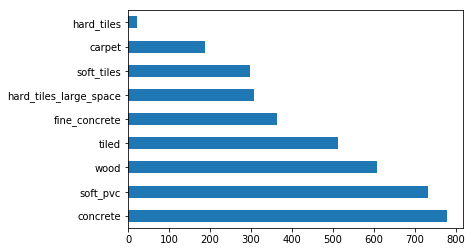

In [8]:
counts = y_train.surface.value_counts().sort_values(ascending=True)
print('The occurrences are:\n', counts)
y_train.surface.value_counts().plot(kind='barh')

## As we can see the dataset is unbalanced then we foresee a great difficult in classifying an hard_tiles surface or a carpet instead of a concrete surface. Probably we need to use some techniques to balance the dataset for the training phase.

## Now the EDA process continues with a deeper analysis into the features we are interested in, the sensor channels. The describe() function get various summary statistics like the mean, the median and the quantiles of the data.

In [9]:
(X_train.iloc[:, 3:]).describe().T

,count,mean,std,min,25%,50%,75%,max
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700
linear_acceleration_Y,487680.0,2.886468,2.140067,-121.49000,1.957900,2.879600,3.798800,73.00800
linear_acceleration_Z,487680.0,-9.364886,2.845341,-75.38600,-10.193000,-9.365300,-8.522700,65.83900


## We point out some behaviors:
+ The mean and the median are very close
+ The maximum and the minimum are very close in absolute value
## These behaviours lead to think there is a kind of symmetry in our dataset.
+ There is a difference between 1st percentile and the minimum for angular velocity and linear acceleration
+ There is a difference between 3rd percentile and the maximum for angular velocity and linear acceleration
## These behaviours lead to think the dataset is affected by the outliers.

## We can verify the presence of outliers with the boxplot, which shows the distribution of data based on median, 1st quartile, 3rd quartile, the maximum and the minimum. The maximum and the minimum described as follows:

$$\large Minimum= Q1 - 1.5*IQR $$
$$\large Maximum= Q3 + 1.5*IQR $$
$$\large IQR = Q3 - Q1 $$

## All the data out of the maximum or minimum bound are the outliers.

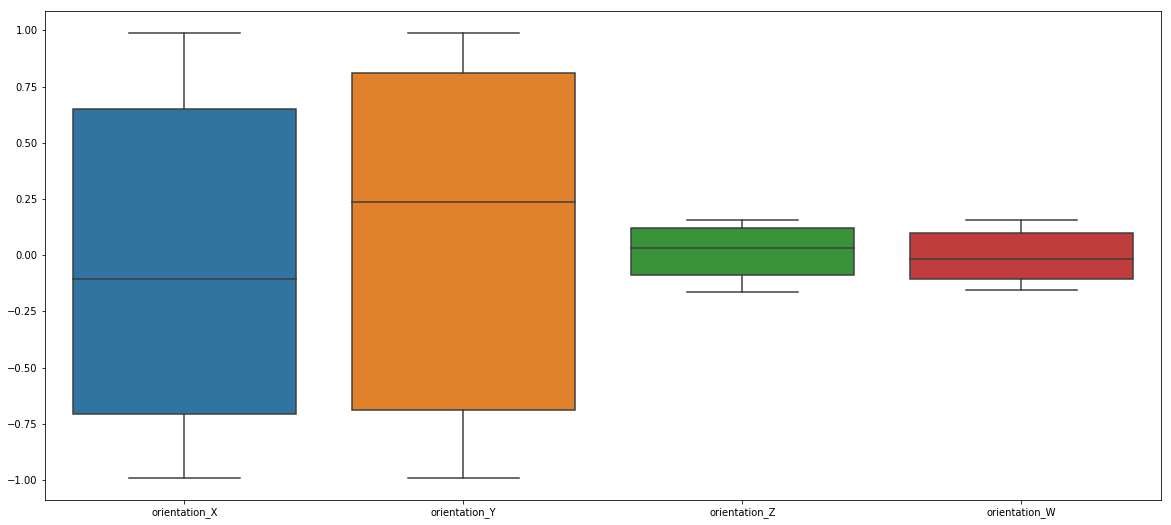

In [10]:
plt.figure(figsize=(20,9))
ax = sns.boxplot(data=X_train.iloc[:, 3:7])
plt.show()

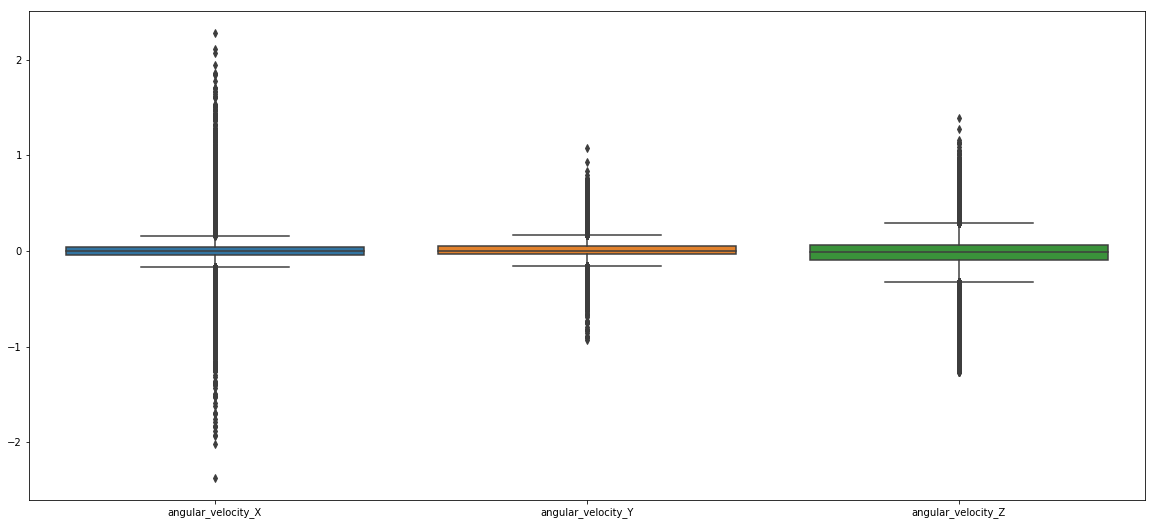

In [11]:
plt.figure(figsize=(20,9))
ax = sns.boxplot(data=X_train.iloc[:, 7:10])
plt.show()

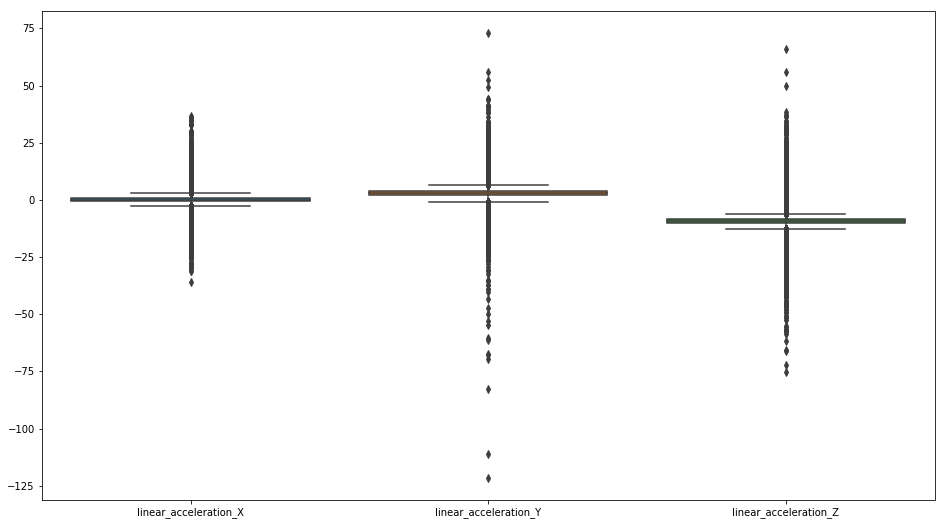

In [12]:
plt.figure(figsize=(16,9))
ax = sns.boxplot(data=X_train.iloc[:, 10:13])
plt.show()

## The boxplots show a common behaviour, which is represented by the colored box but also they show a heavy presence of outliers on the angular velocity and the linear acceleration but as we have seen before we think there is a symmetry on our data, then we can plot the distribution of our data by feature to evaluate the skewness.

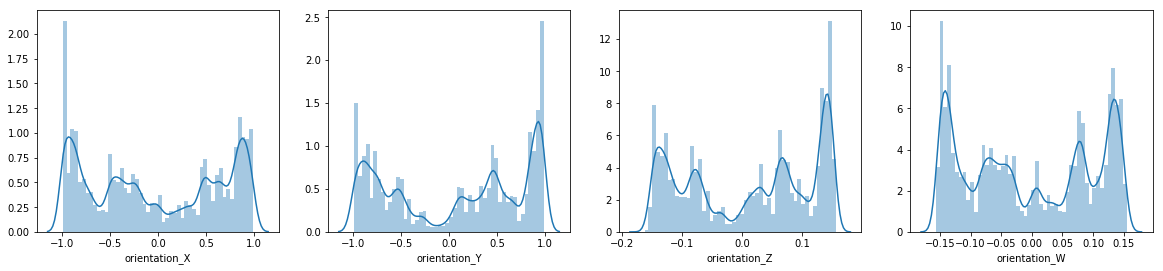

In [13]:
l = (X_train.iloc[:, 3:7]).columns.values
n_cols = 4
n_rows = len(l)-1/n_cols
plt.figure(figsize=(5*n_cols, 5*n_rows))
for j in range(0, len(l)):
    plt.subplot(n_rows+1, n_cols, j+1)
    sns.distplot((X_train.iloc[:,3:7])[l[j]], kde=True) 

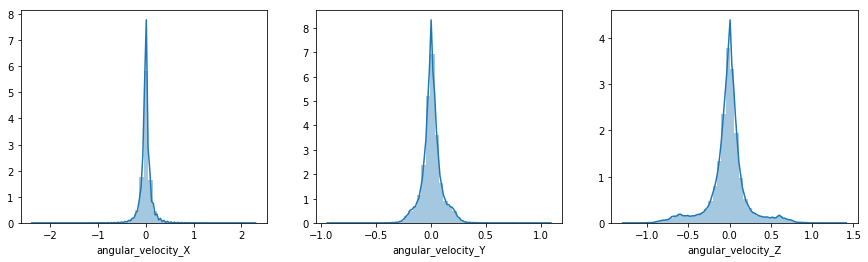

In [14]:
l = (X_train.iloc[:, 7:10]).columns.values
n_cols = 3
n_rows = len(l)-1/n_cols
plt.figure(figsize=(5*n_cols, 5*n_rows))
for j in range(0, len(l)):
    plt.subplot(n_rows+1, n_cols, j+1)
    sns.distplot((X_train.iloc[:,7:10])[l[j]], kde=True) 

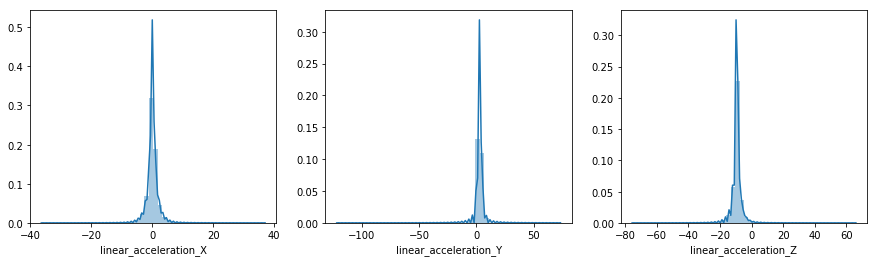

In [15]:
l = (X_train.iloc[:, 10:13]).columns.values
n_cols = 3
n_rows = len(l)-1/n_cols
plt.figure(figsize=(5*n_cols, 5*n_rows))
for j in range(0, len(l)):
    plt.subplot(n_rows+1, n_cols, j+1)
    sns.distplot((X_train.iloc[:,10:13])[l[j]], kde=True) 

## These plots shows a kind of symmetry of our data, in fact the angular velocity and the linear acceleration can be assumed normally distributed, and the outliers can be traced back to some behaviors referable to peaks of acceleration or angular velocity carried out by the robot in certain situations. Then we think the substitution of the outliers with the mean or the median value is not a correct choice because it would lead to a flat behavior of the robot and an information loss on certain behaviors.

## This decision can be further validated through an analysis of the boxplots and skewness done by surface class. We decide to make this analysis to understand if the previous study is conditioned by the majority surface classes or if this behavior is also present on hard_tiles or any other minority surfaces.

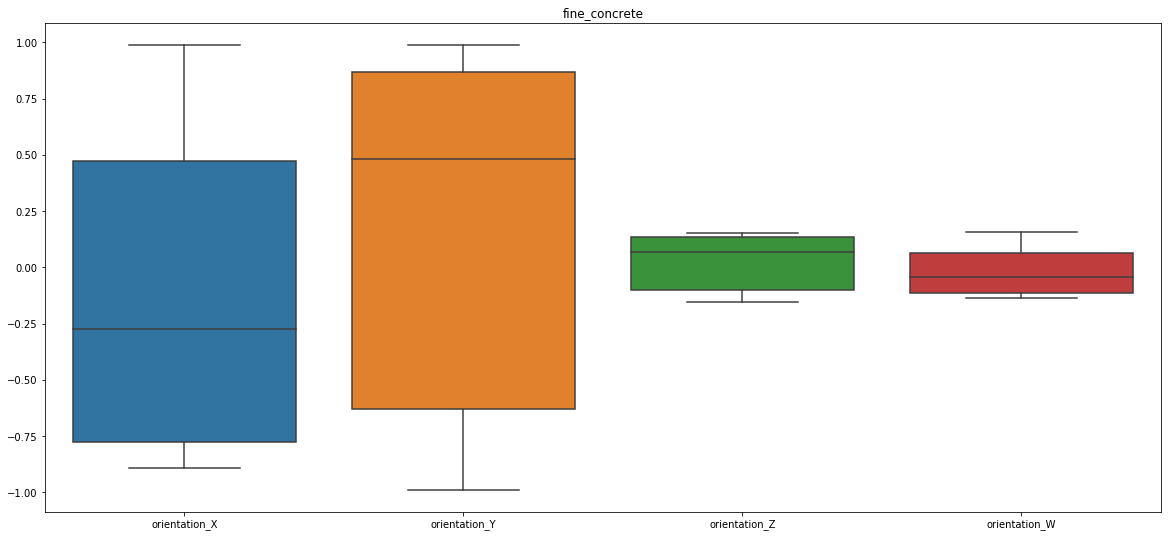

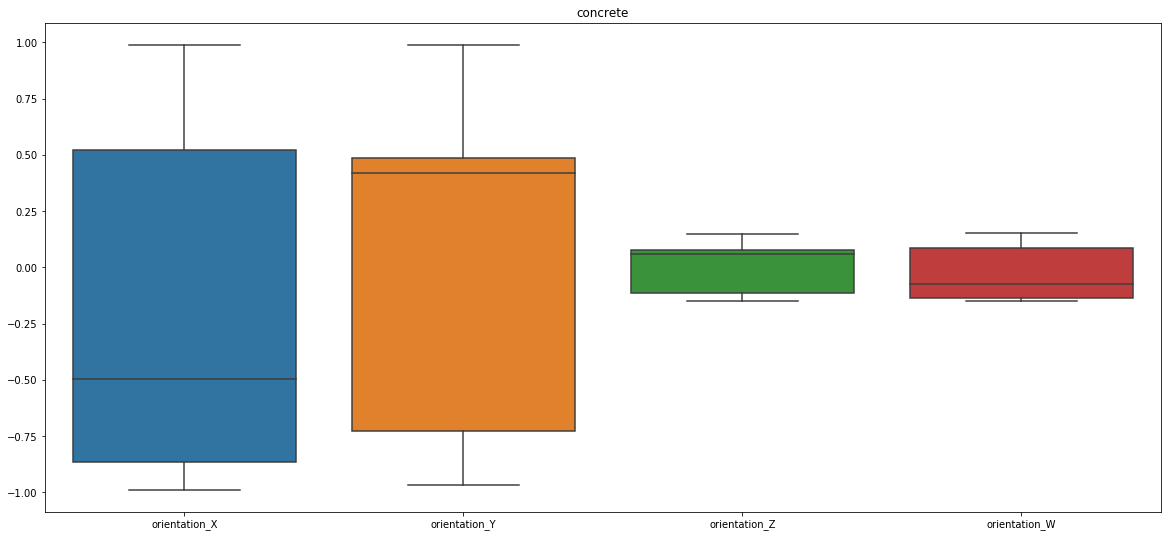

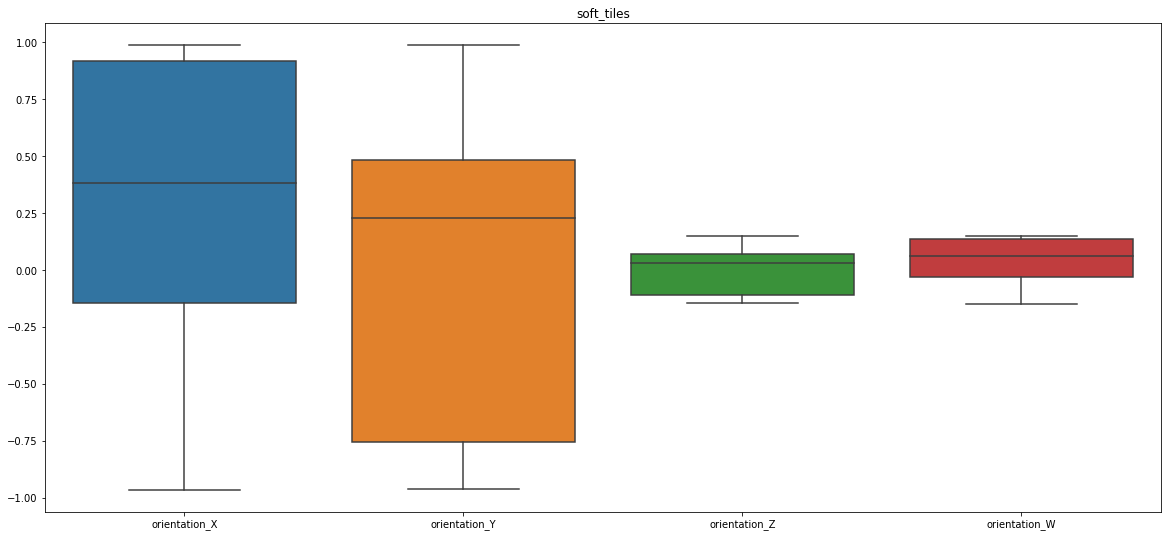

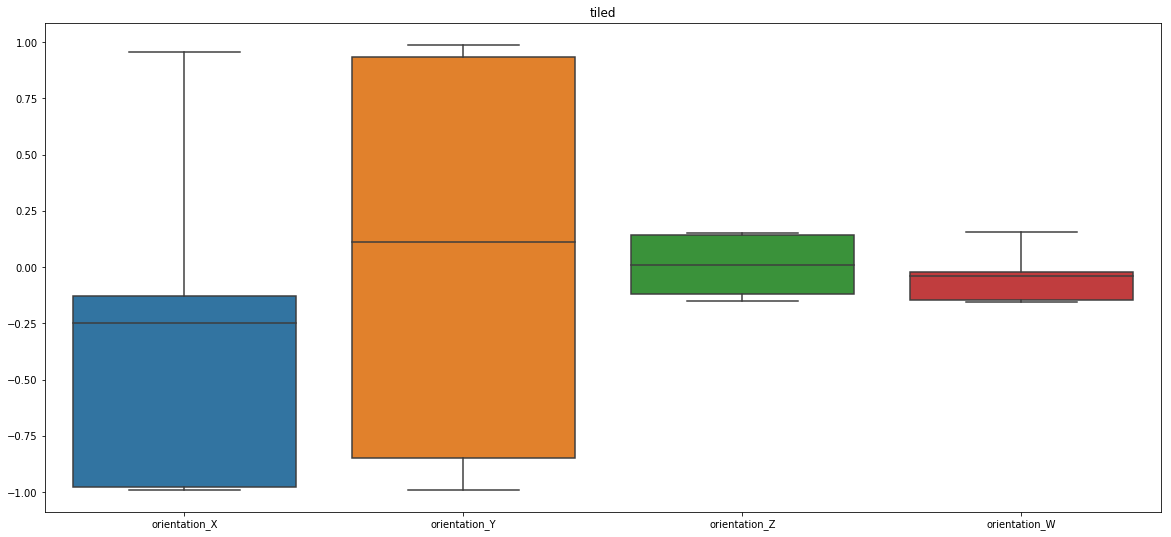

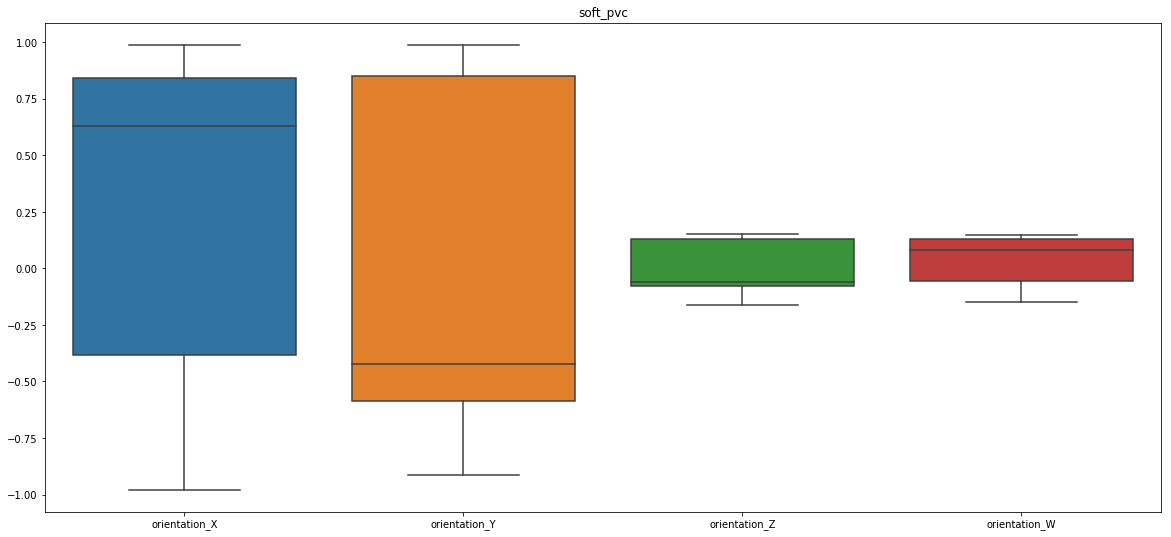

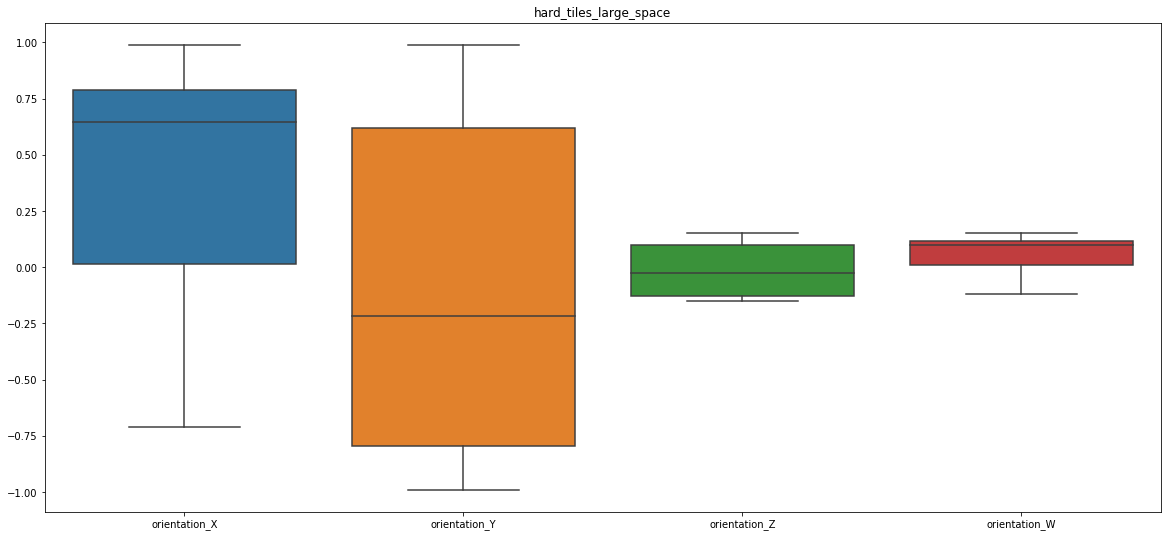

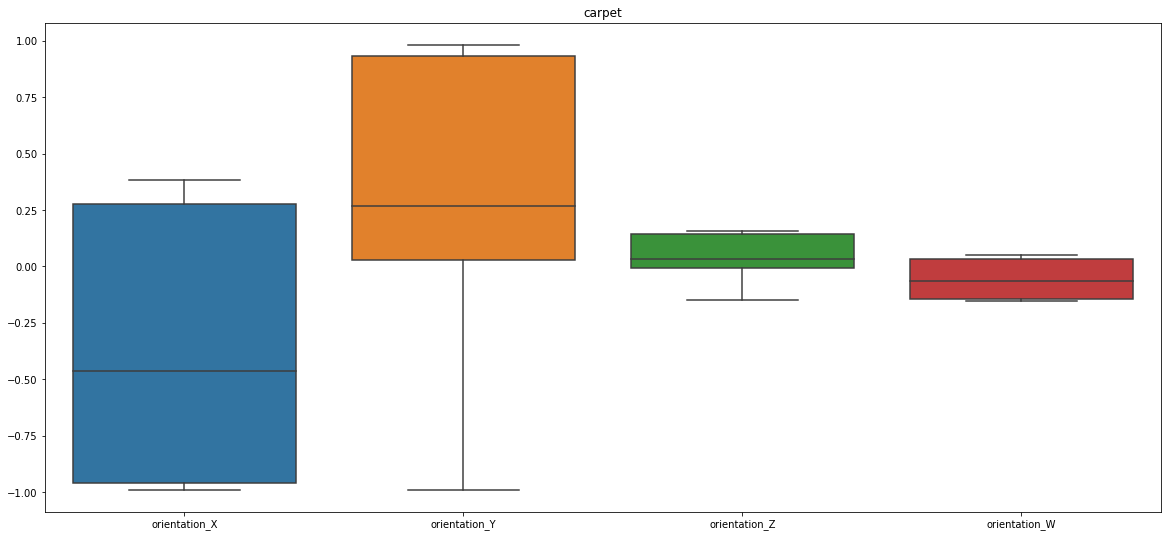

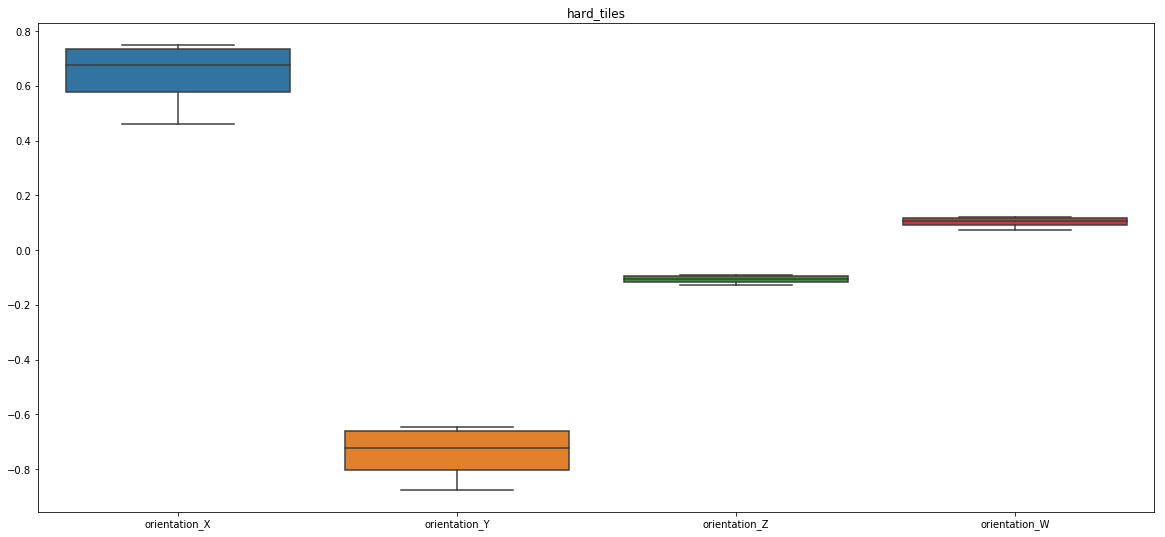

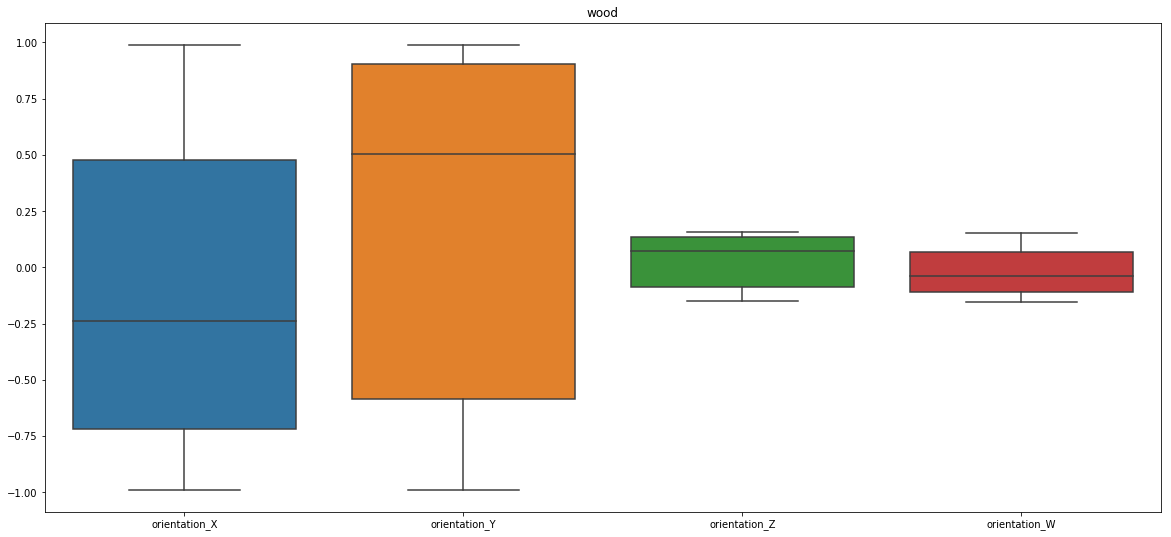

In [16]:
classes = y_train['surface'].unique()
dataset = X_train.merge(y_train, on = 'series_id', how = 'inner')
for i in range(len(classes)):
    is_class = dataset['surface'] == classes[i]
    material = dataset[is_class]
    plt.figure(figsize=(20,9))
    ax = sns.boxplot(data=material.iloc[:, 3:7])
    plt.title(classes[i])
    plt.show()

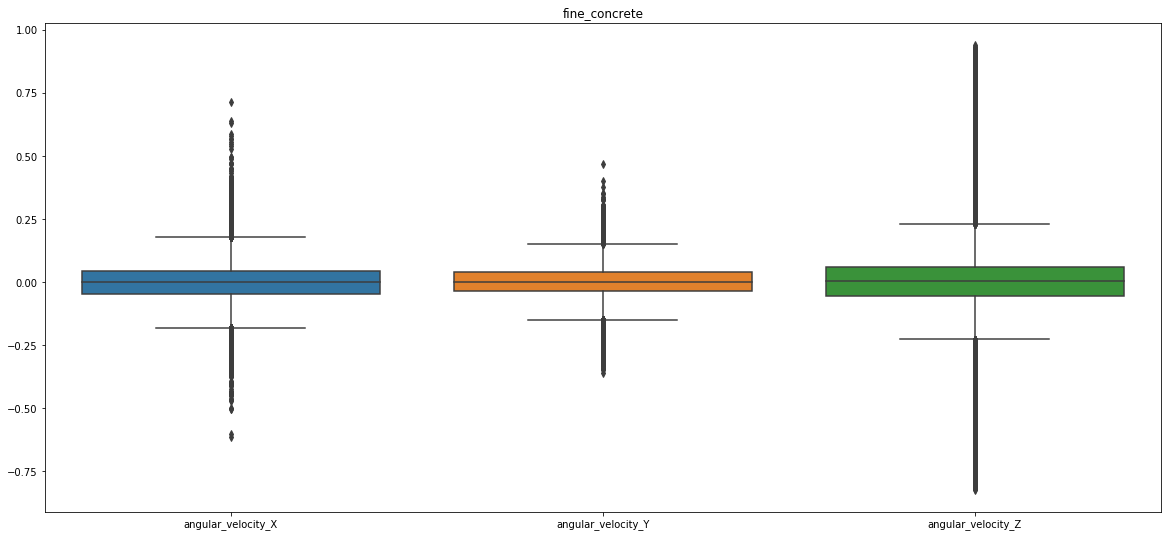

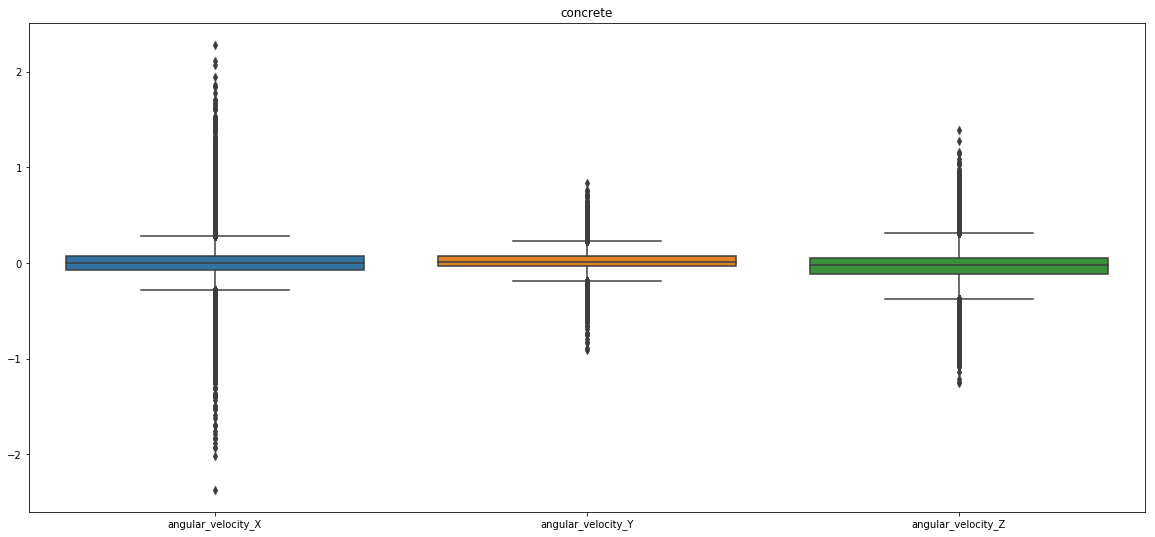

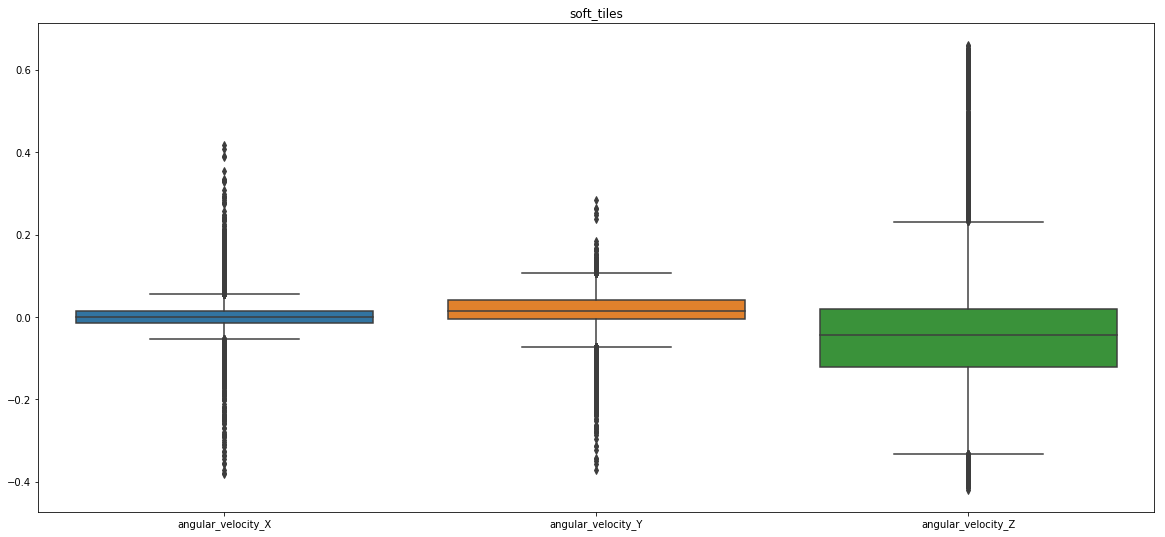

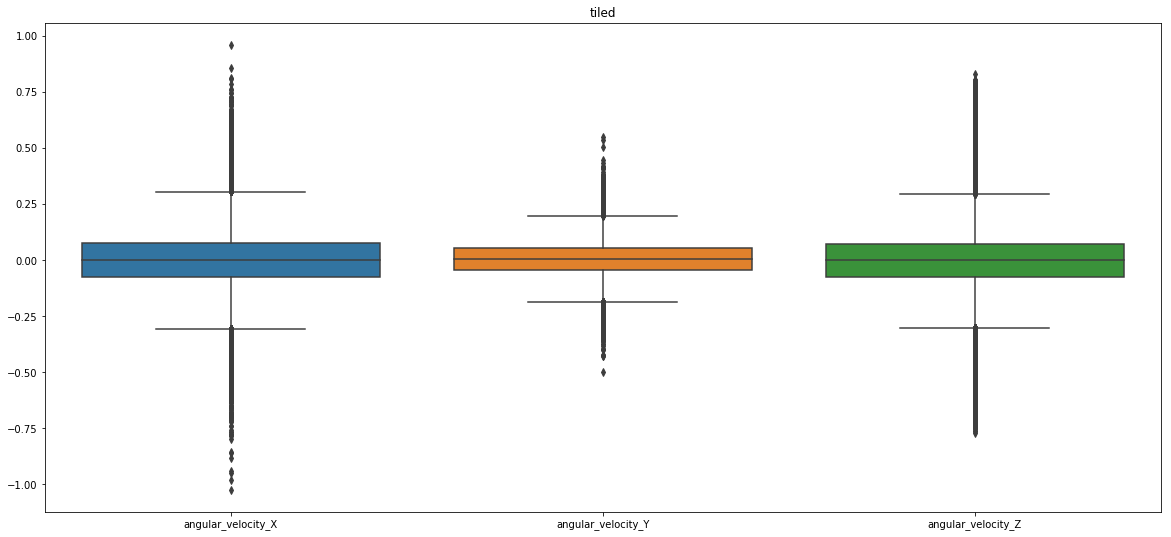

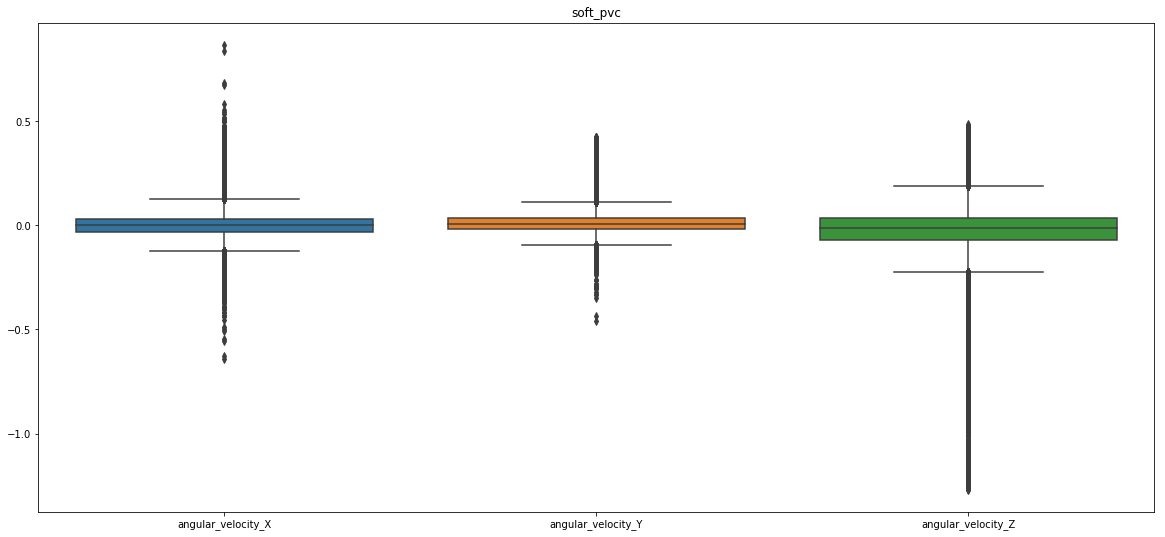

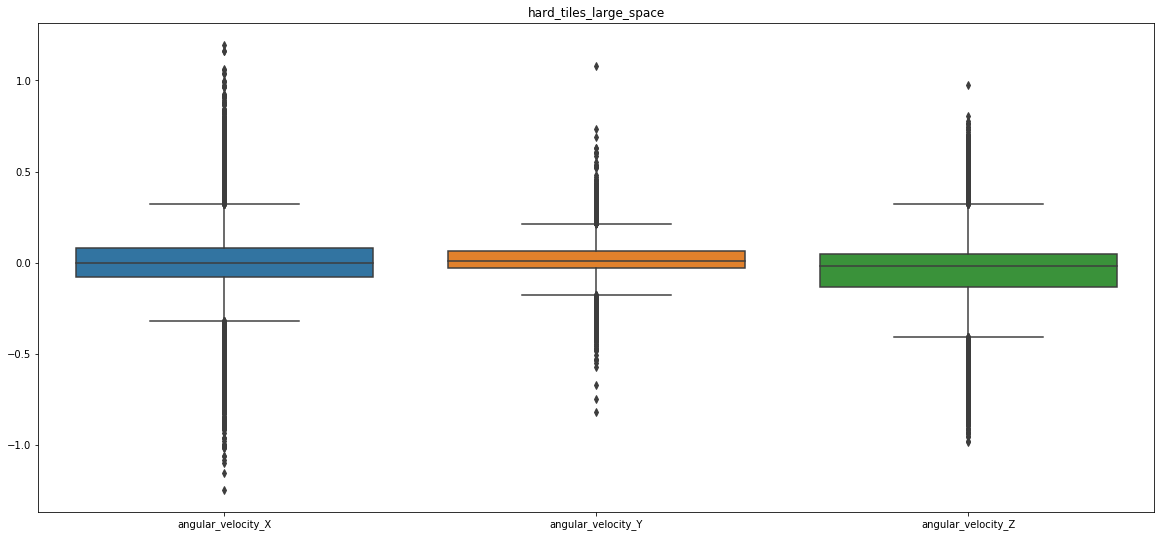

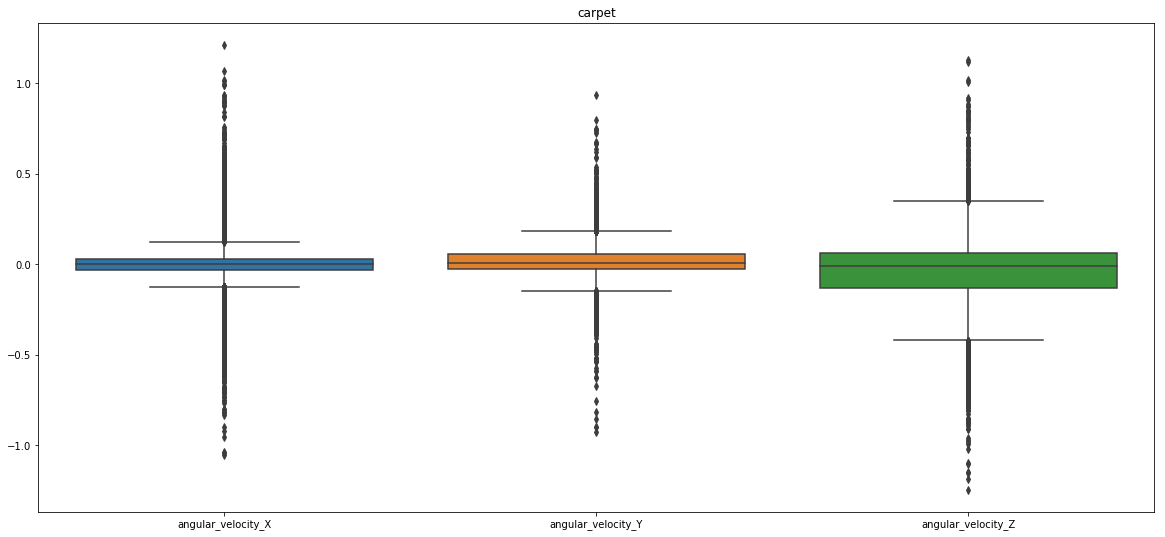

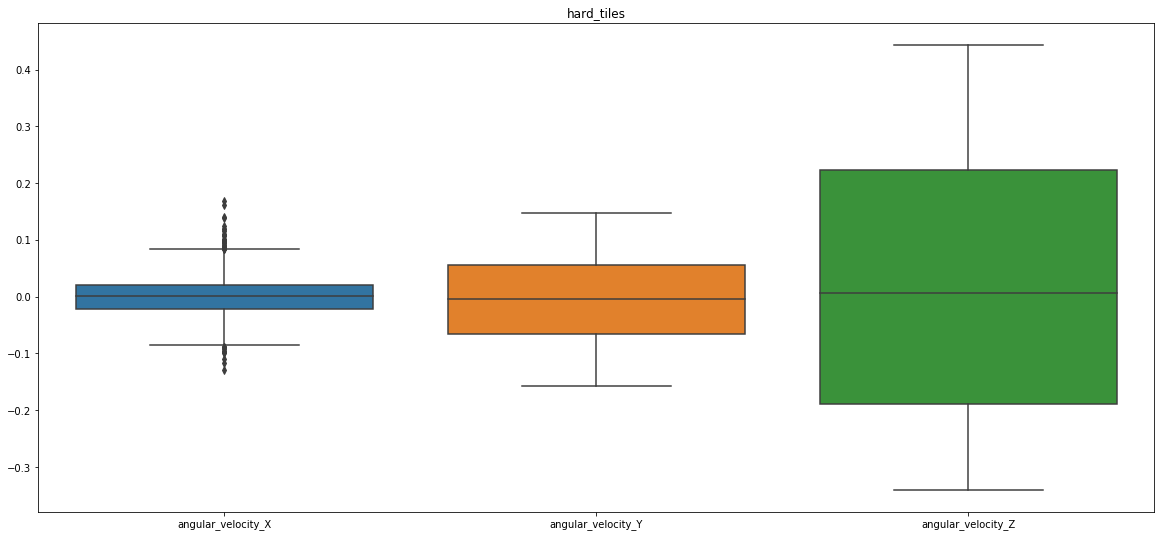

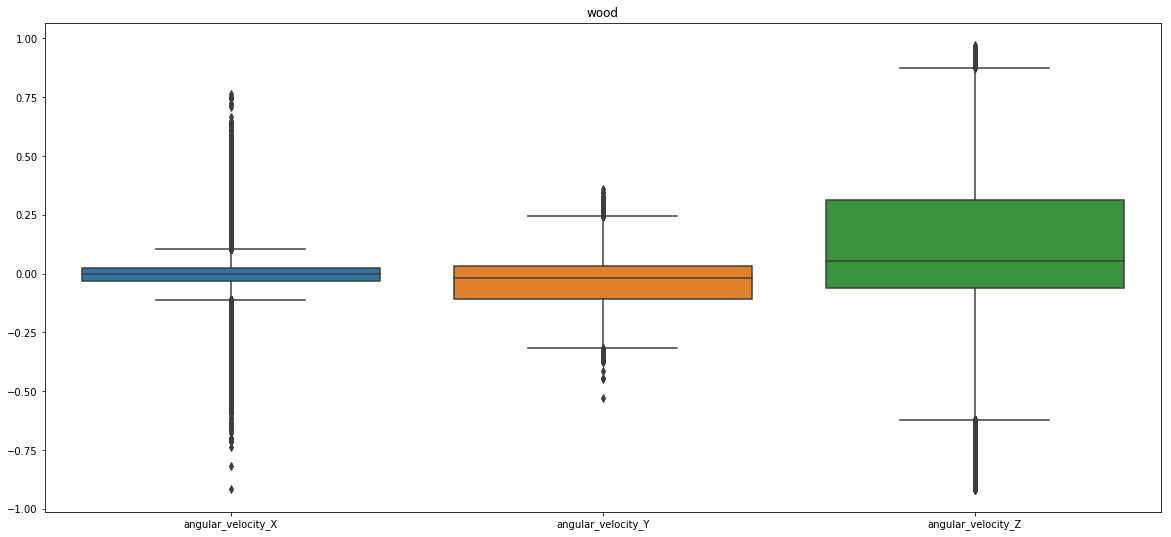

In [17]:
for i in range(len(classes)):
    is_class = dataset['surface'] == classes[i]
    material = dataset[is_class]
    plt.figure(figsize=(20,9))
    ax = sns.boxplot(data=material.iloc[:, 7:10])
    plt.title(classes[i])
    plt.show()

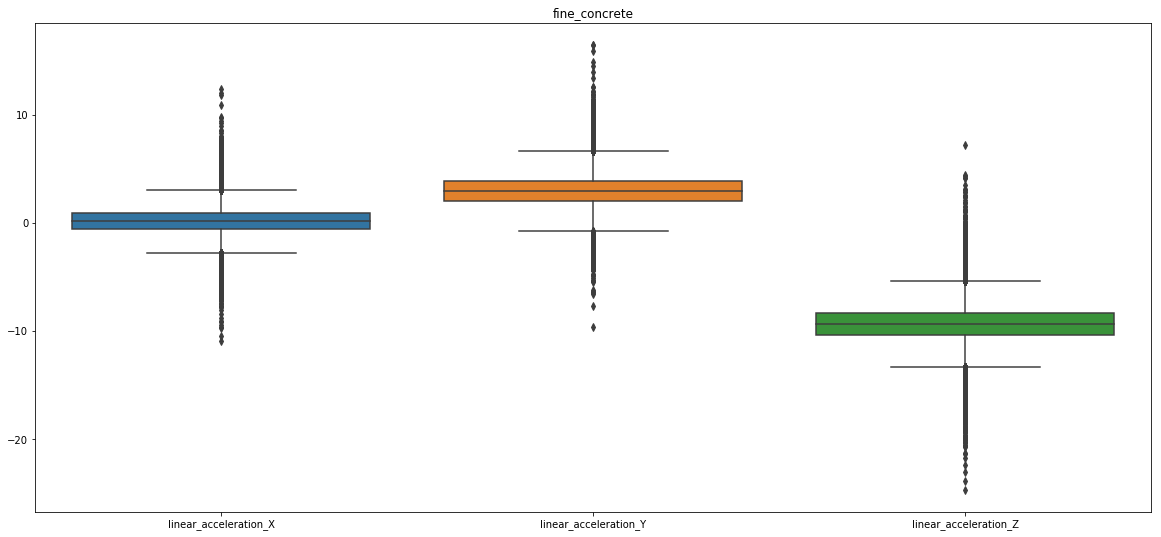

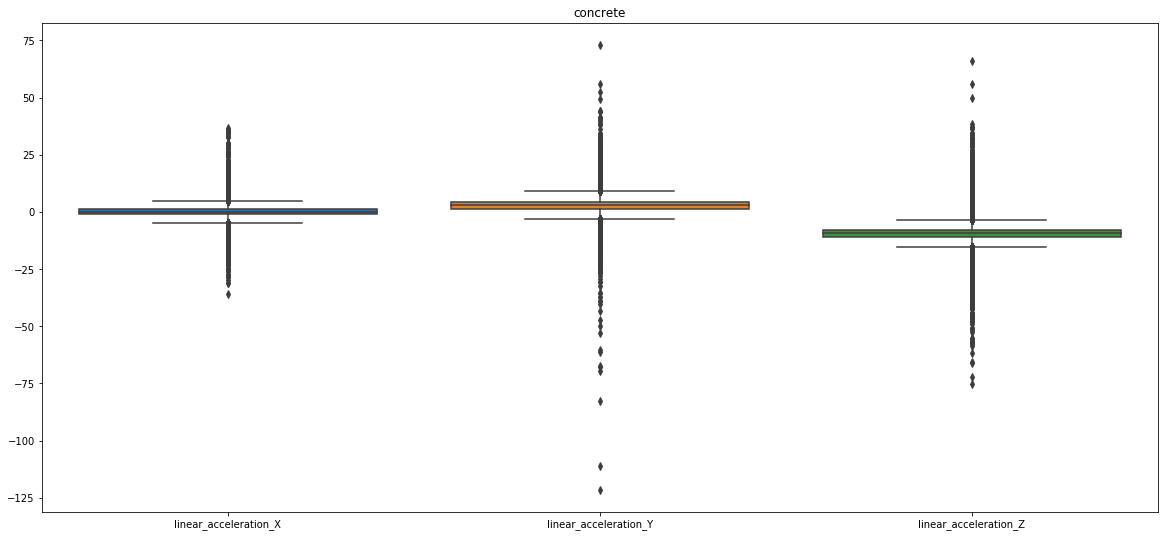

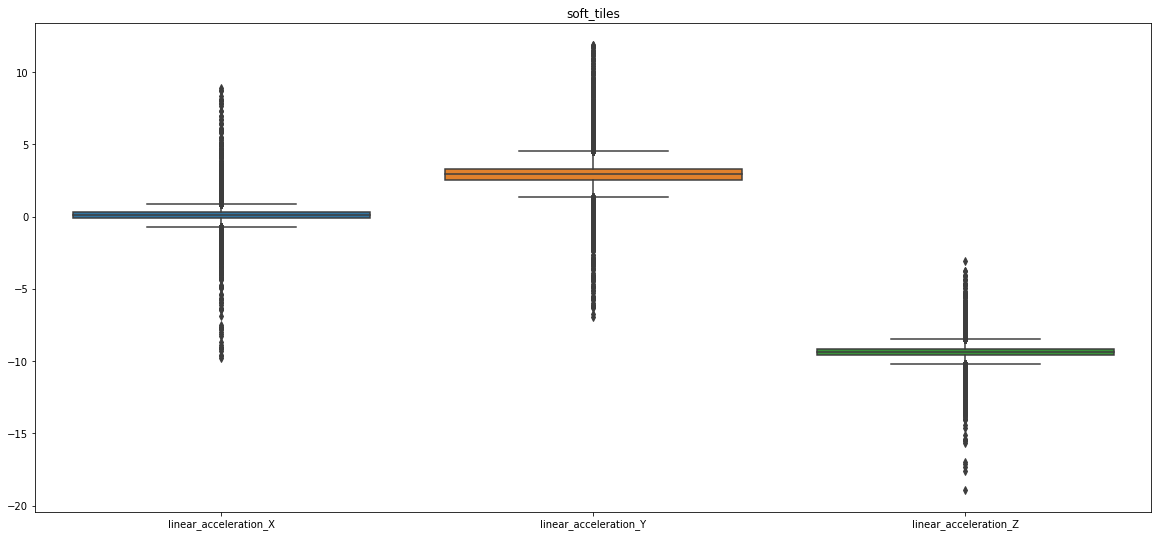

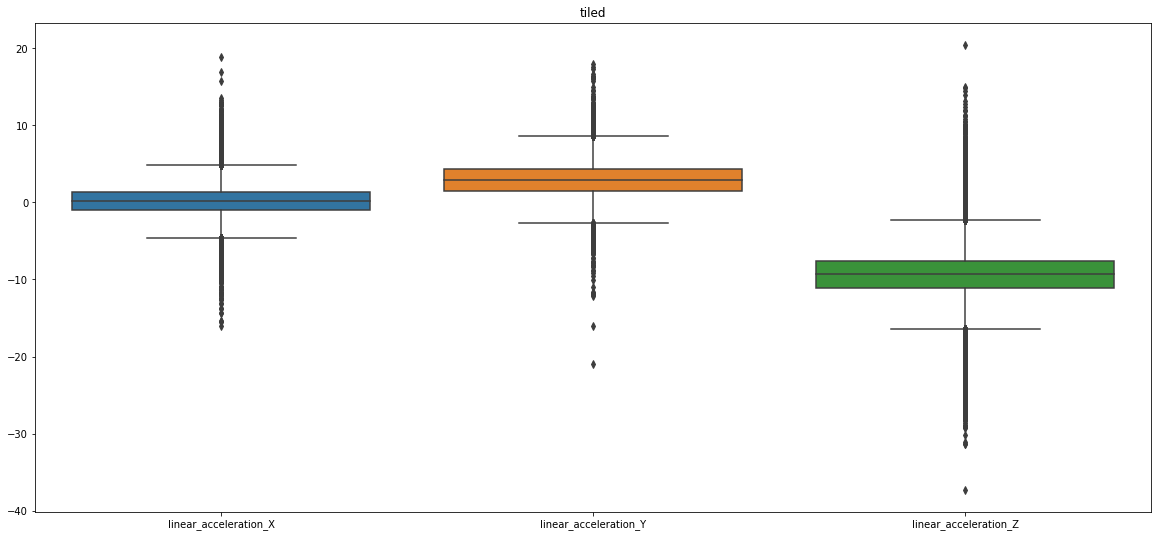

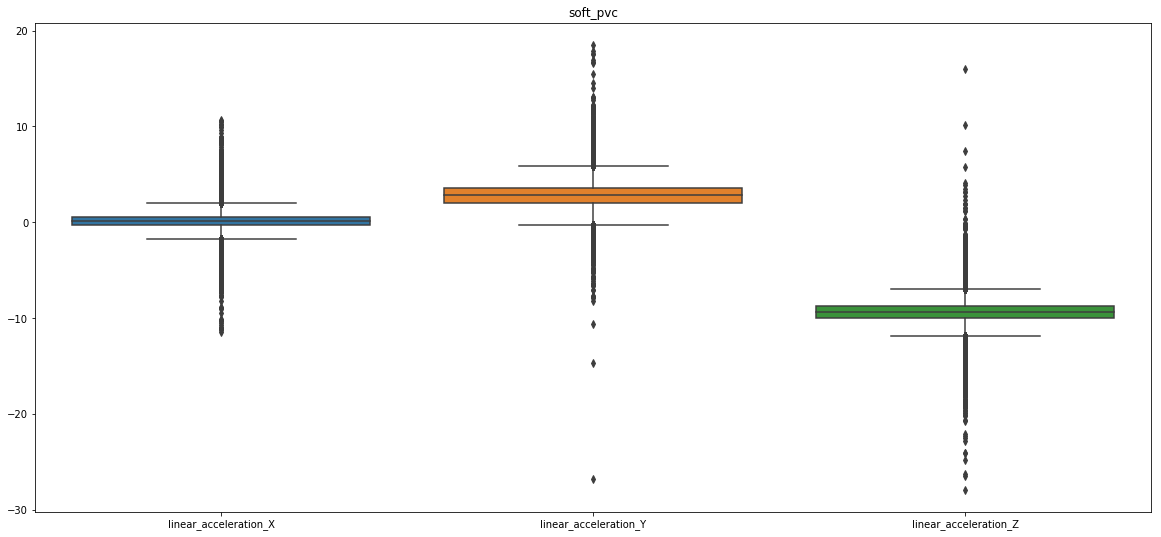

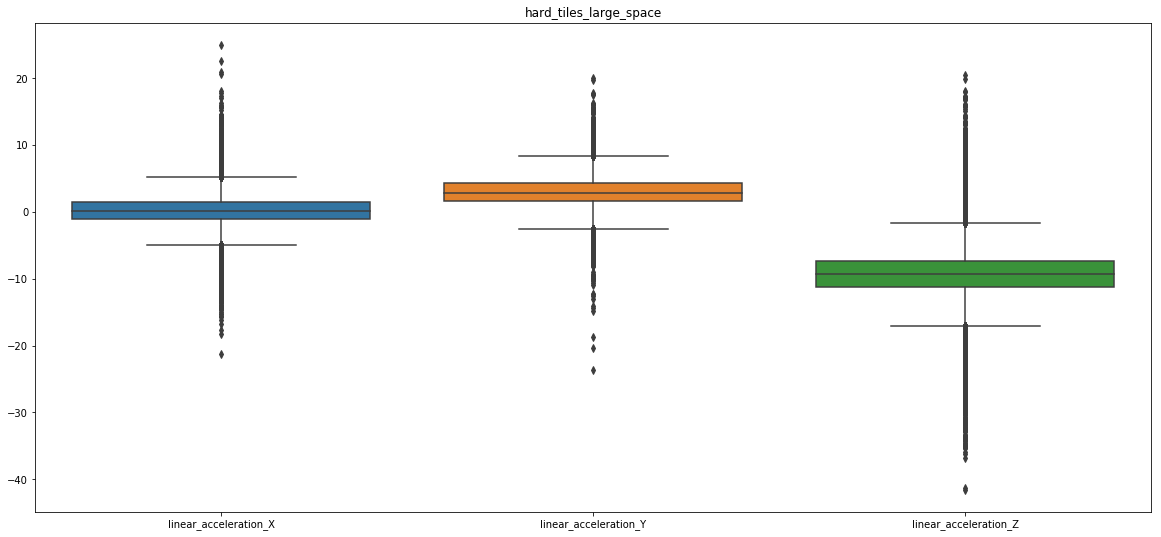

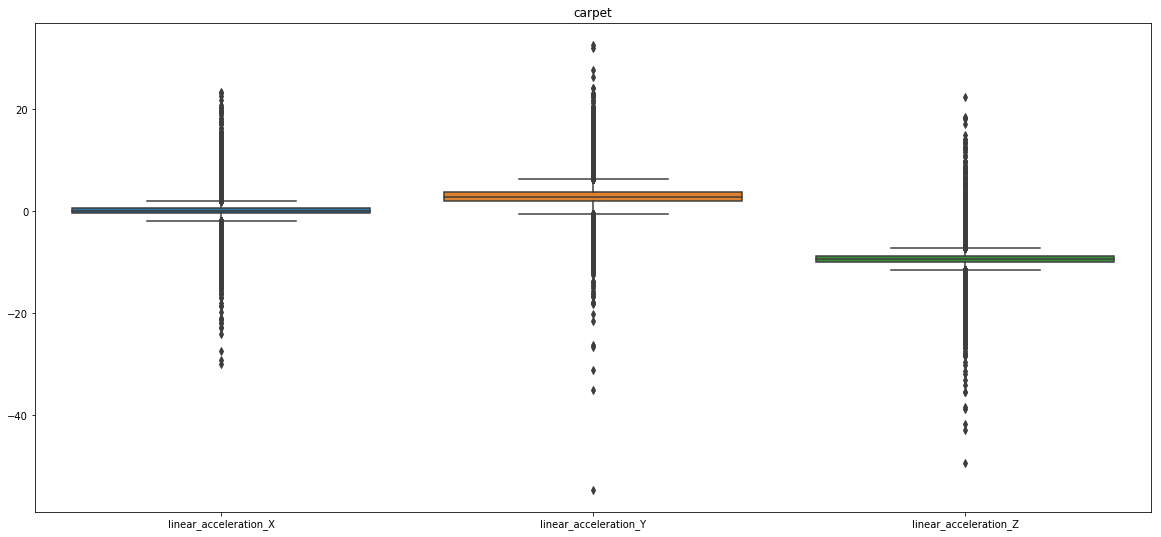

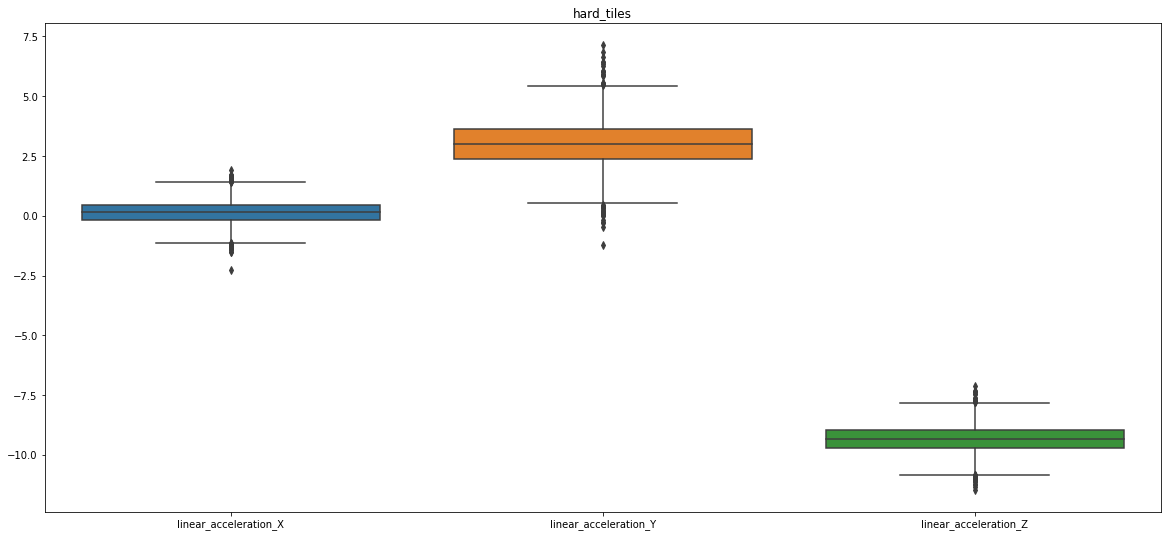

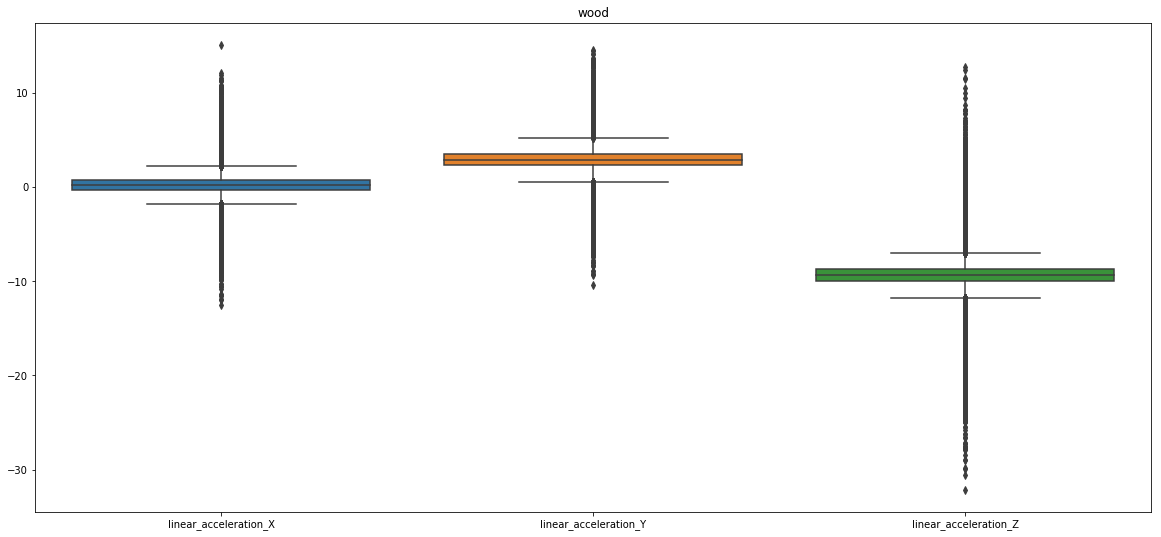

In [18]:
for i in range(len(classes)):
    is_class = dataset['surface'] == classes[i]
    material = dataset[is_class]
    plt.figure(figsize=(20,9))
    ax = sns.boxplot(data=material.iloc[:, 10:13])
    plt.title(classes[i])
    plt.show()

## Another important measure used to explore data is the Pearson correlation; It describes the relationship between two variables and it ranges from 1 (positive correlation) to -1 (negative correlation). The positive correlation means that one variable increases as the other increases while the negative correlation means that one variable decreases as the other increases.

Text(0.5, 1.0, 'Correlation Matrix')

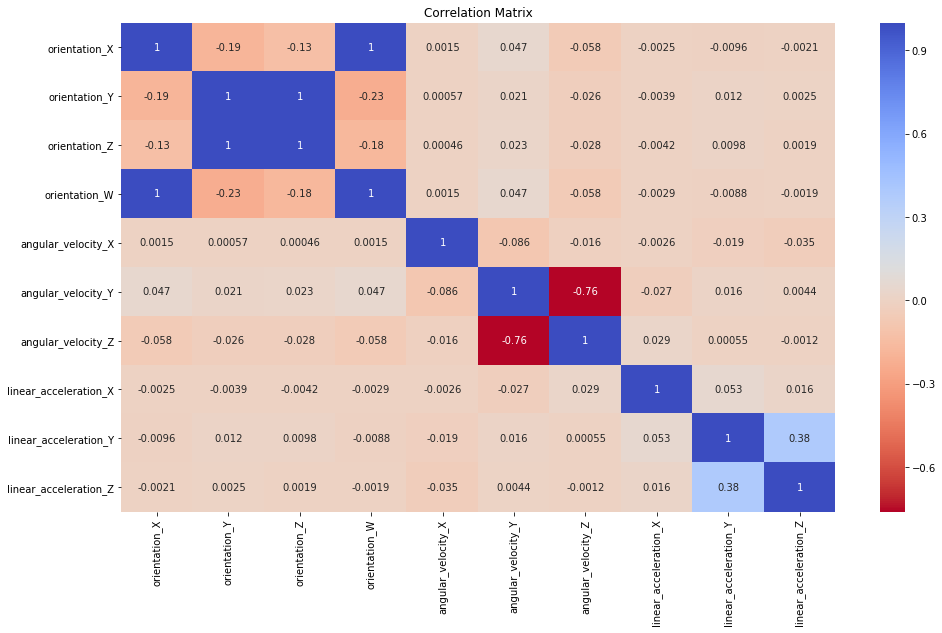

In [19]:
columns = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',\
           'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y',\
           'linear_acceleration_Z']
f, (ax1) = plt.subplots(1, 1, figsize=(16, 9))
correlation_matrix = (X_train[columns]).corr(method='pearson')
sns.heatmap(correlation_matrix, cmap='coolwarm_r', annot= True, annot_kws={'size':10})
ax1.set_title('Correlation Matrix')

## The correlation matrix shows:
+ An high positive correlation between orientation_X and orientation_W
+ An high positive correlation between orientation_Y and orientation_Z
+ An high negative correlation between angular_velocity_Y and angular_velocity_Z

## !!!!!! Capire la dipendenza tra le variabili. sistemi inerziali? !!!!!!!!!!!!!

## Now let's explore the time series in order to find
+ different trends between time series related to different surfaces
+ affinities identifiable graphically between time series related to the same surface

In [20]:
y_train.head(50)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
5,5,1,tiled
6,6,34,soft_pvc
7,7,31,concrete
8,8,33,hard_tiles_large_space
9,9,11,tiled


## First Observation: we show the trends for different surfaces.

In [21]:
concrete = X_train.iloc[128*1:128*1+128]
f_concrete = X_train.iloc[128*0:128*0+128]
s_tile = X_train.iloc[128*4:128*4+128]
tiled = X_train.iloc[128*5:128*5+128]
s_pvc = X_train.iloc[128*6:128*6+128]
hard_tile_large = X_train.iloc[128*8:128*8+128]
carpet = X_train.iloc[128*12:128*12+128]
hard_tile = X_train.iloc[128*27:128*27+128]
wood = X_train.iloc[128*39:128*39+128]

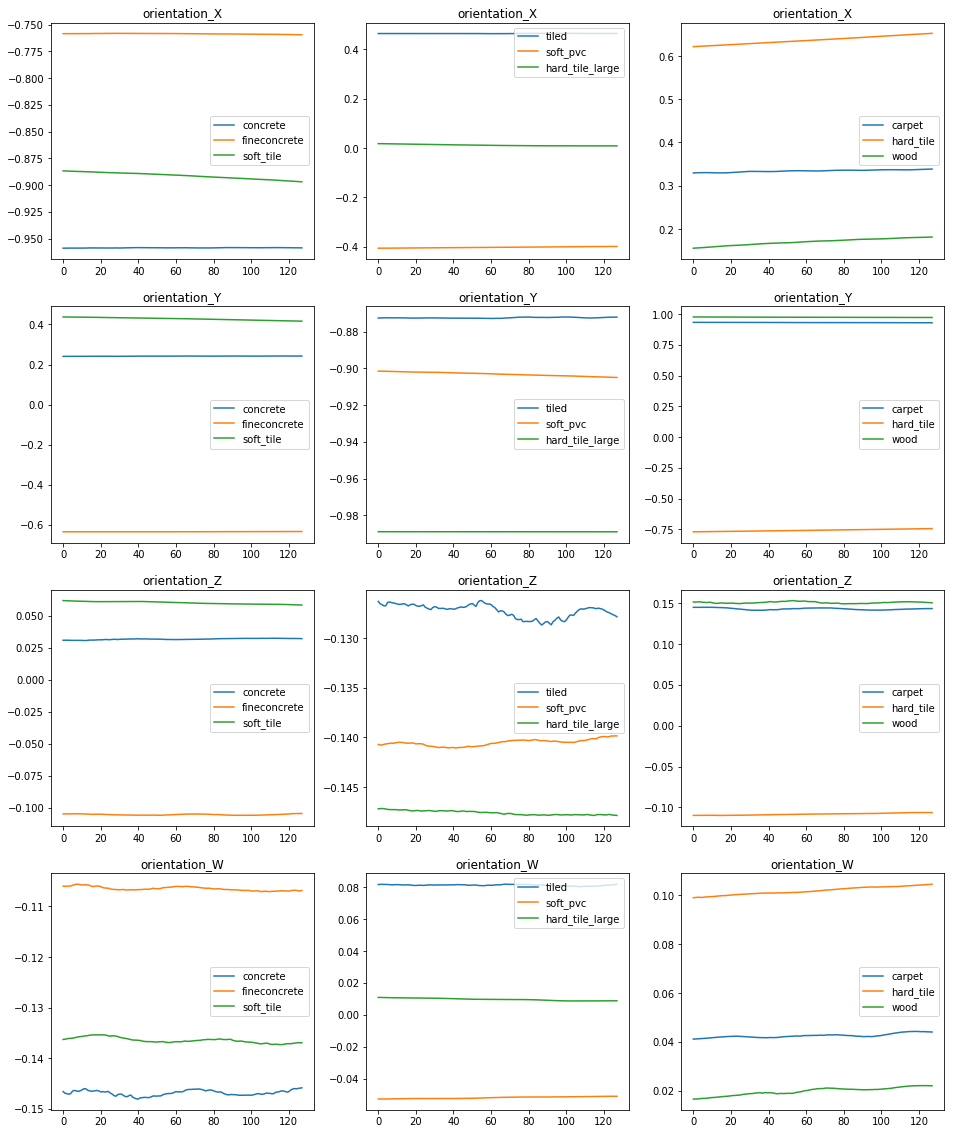

In [47]:
fig = plt.figure(figsize=(16,20))
t = np.arange(0, 128, 1)
for i, col in enumerate(X_train.columns[3:7]):
    plt.subplot(4, 3, (i*3)+1)
    plt.plot(t, concrete[col], label= 'concrete')
    plt.plot(t, f_concrete[col], label= 'fineconcrete')
    plt.plot(t, s_tile[col], label= 'soft_tile')
    plt.title(col)
    plt.legend()
    plt.subplot(4, 3, (i*3)+2)
    plt.plot(t, tiled[col], label= 'tiled')
    plt.plot(t, s_pvc[col], label= 'soft_pvc')
    plt.plot(t, hard_tile_large[col], label= 'hard_tile_large')
    plt.title(col)
    plt.legend()
    plt.subplot(4, 3, (i*3)+3)
    plt.plot(t, carpet[col], label= 'carpet')
    plt.plot(t, hard_tile[col], label= 'hard_tile')
    plt.plot(t, wood[col], label= 'wood')
    plt.title(col)
    plt.legend()

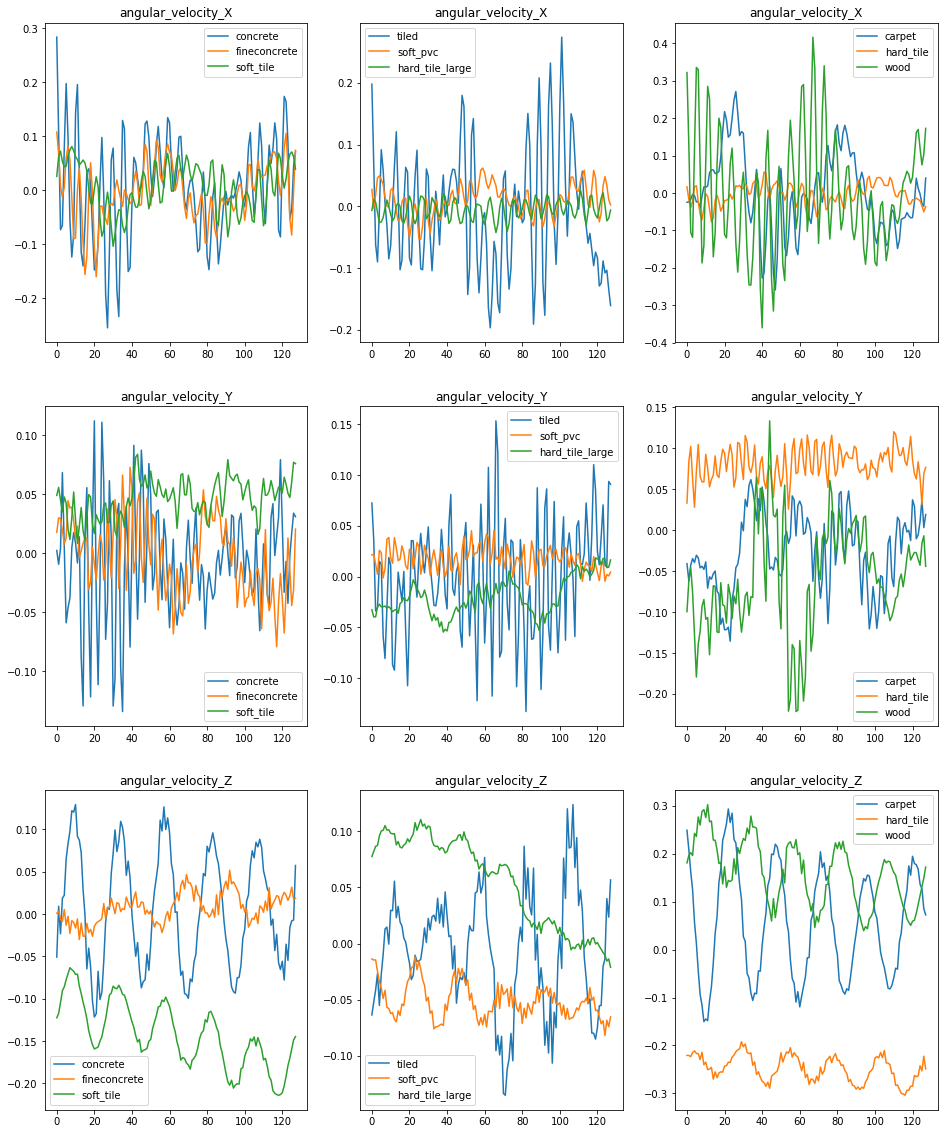

In [48]:
fig = plt.figure(figsize=(16,20))
t = np.arange(0, 128, 1)
for i, col in enumerate(X_train.columns[7:10]):
    plt.subplot(3, 3, (i*3)+1)
    plt.plot(t, concrete[col], label= 'concrete')
    plt.plot(t, f_concrete[col], label= 'fineconcrete')
    plt.plot(t, s_tile[col], label= 'soft_tile')
    plt.title(col)
    plt.legend()
    plt.subplot(3, 3, (i*3)+2)
    plt.plot(t, tiled[col], label= 'tiled')
    plt.plot(t, s_pvc[col], label= 'soft_pvc')
    plt.plot(t, hard_tile_large[col], label= 'hard_tile_large')
    plt.title(col)
    plt.legend()
    plt.subplot(3, 3, (i*3)+3)
    plt.plot(t, carpet[col], label= 'carpet')
    plt.plot(t, hard_tile[col], label= 'hard_tile')
    plt.plot(t, wood[col], label= 'wood')
    plt.title(col)
    plt.legend()

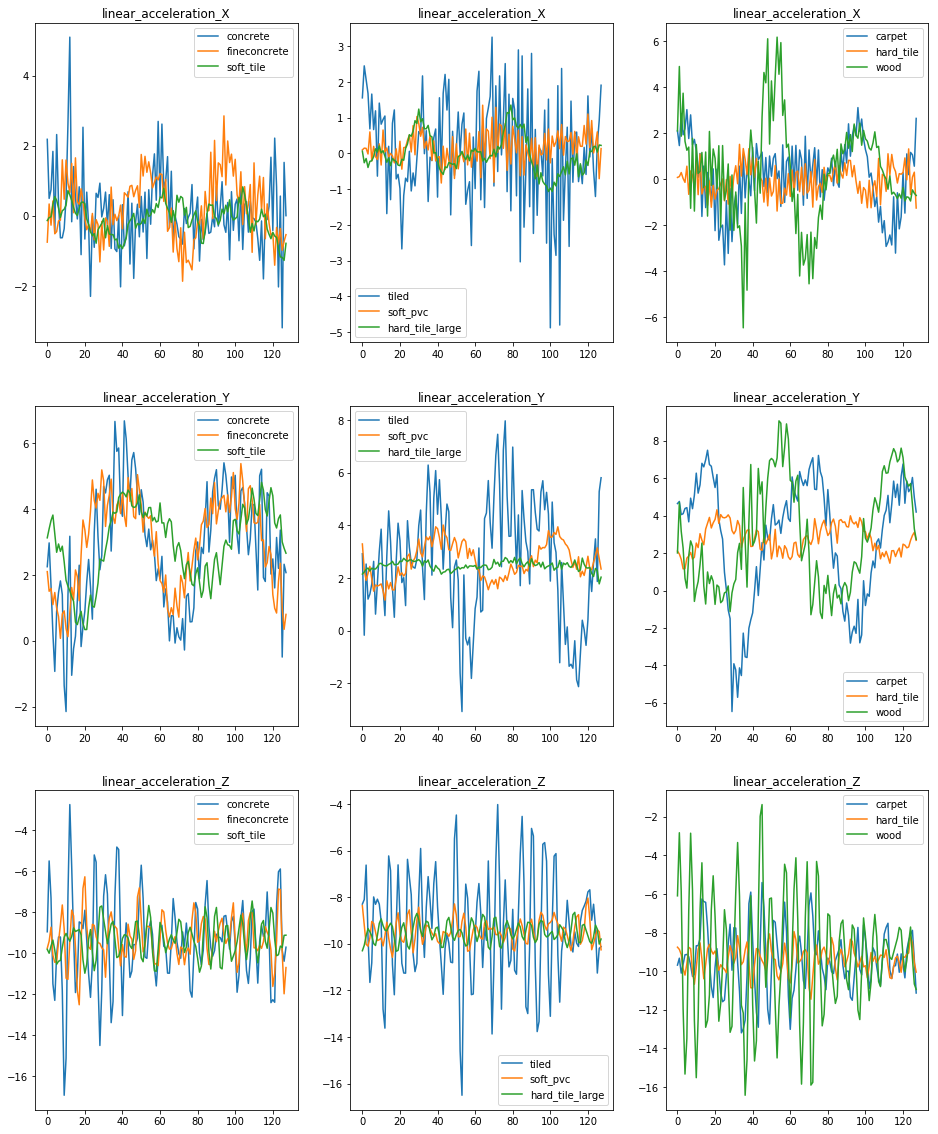

In [49]:
fig = plt.figure(figsize=(16,20))
t = np.arange(0, 128, 1)
for i, col in enumerate(X_train.columns[10:13]):
    plt.subplot(3, 3, (i*3)+1)
    plt.plot(t, concrete[col], label= 'concrete')
    plt.plot(t, f_concrete[col], label= 'fineconcrete')
    plt.plot(t, s_tile[col], label= 'soft_tile')
    plt.title(col)
    plt.legend()
    plt.subplot(3, 3, (i*3)+2)
    plt.plot(t, tiled[col], label= 'tiled')
    plt.plot(t, s_pvc[col], label= 'soft_pvc')
    plt.plot(t, hard_tile_large[col], label= 'hard_tile_large')
    plt.title(col)
    plt.legend()
    plt.subplot(3, 3, (i*3)+3)
    plt.plot(t, carpet[col], label= 'carpet')
    plt.plot(t, hard_tile[col], label= 'hard_tile')
    plt.plot(t, wood[col], label= 'wood')
    plt.title(col)
    plt.legend()

## These plots show certain trends on different surfaces then we can use this information to extract important features for our classification model like the maximum value and the minimum value, the max-min range useful for angular velocity and linear acceleration or the mean value for orientation.

## Second Observation: we try to spot affinities identifiable graphically between time series related to the same surface.

## We show just an example about surface 'wood' but this behavior is common to the other surfaces.

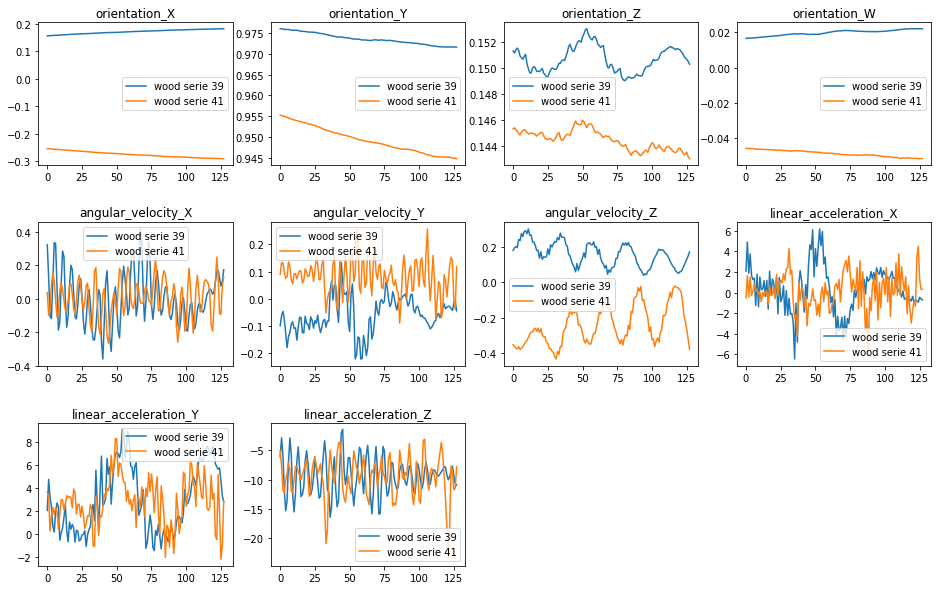

In [50]:
s1 = X_train.iloc[128*39:128*39+128]
s2 = X_train.iloc[128*41:128*41+128]
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.4)
t = np.arange(0, 128, 1)
for i, col in enumerate(s1.columns[3:]):
    plt.subplot(3, 4, i+1)
    plt.plot(t, s1[col], label='wood serie 39')
    plt.plot(t, s2[col], label='wood serie 41')
    plt.title(col)
    plt.legend()

## These plots show different trends in two different series on the same surface then we point out these different behaviors.

## Both the two observation exhibit noisy plots then we can try to improve the measurements using the Fast Fourier Transform combined with a Low Pass Filter. Moreover, we think the FFT data can be used in the feature engineering phase to extract more knowledge about our data.
## The noise removal does not compromise data information content but on the contrary it makes them more suitable for feature engineering purposes.
## We create 2 other csv files: one with our data cleaned by low pass filter and the other with the data cleaned in the frequency domain.

In [26]:
def filter_signal(signal, threshold=800):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

def fft_lowpass(signal, threshold=800):
    fourier = fft(signal)
    frequencies = fftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return fourier

In [126]:
'''
col= 'orientation_X'
data = X_train.groupby(['series_id'])[col].apply(lambda x: filter_signal(x))
xx = data.to_numpy()
#xx.reshape(3810, 128)
ss = np.stack(xx, axis=0 )
ss = ss.reshape(3810*128, 1)
#provaa = X_train.copy()
# len(provaa.loc[i*128:i*128+127, col])
'''

array([[-0.75889797],
       [-0.75867   ],
       [-0.75851088],
       ...,
       [ 0.62893946],
       [ 0.62909788],
       [ 0.62924888]])

In [27]:
# clean_X_train = X_train.copy()
# for col in X_train.columns[3:13]:
#     mycol = []
#     data = X_train.groupby(['series_id'])[col].apply(lambda x: filter_signal(x))
#     for i in range(data.shape[0]):
#         for j in range(data[i].shape[0]):
#             mycol.append(data[i][j])
#     clean_X_train[col] = mycol
# clean_X_train.to_csv('./clean_X_train.csv', index=False)

In [28]:
# fft_X_train = X_train.copy()
# for col in X_train.columns[3:13]:
#     mycol = []
#     fft_data = X_train.groupby(['series_id'])[col].apply(lambda x: fft_lowpass(x))
#     for i in range(fft_data.shape[0]):
#         for j in range(fft_data[i].shape[0]):
#             mycol.append(abs(fft_data[i][j]))
#     fft_X_train[col] = mycol
# fft_X_train.to_csv('./fft_X_train.csv', index=False)

In [29]:
cleaned = pd.read_csv('./clean_X_train.csv', engine='python')
cleaned.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.758898,-0.633863,-0.104810,-0.106346,0.035759,0.012754,0.007480,-0.275146,1.378036,-10.511627
1,0_1,0,1,-0.758670,-0.634158,-0.104878,-0.106143,0.049310,0.018677,0.001782,-0.155895,1.460815,-10.462078
2,0_2,0,2,-0.758511,-0.634368,-0.104921,-0.105977,0.054628,0.021799,-0.002665,-0.130949,1.481009,-10.100441
3,0_3,0,3,-0.758440,-0.634469,-0.104931,-0.105866,0.050403,0.023290,-0.005565,-0.177549,1.411162,-9.632229
4,0_4,0,4,-0.758446,-0.634475,-0.104914,-0.105803,0.039355,0.024656,-0.007160,-0.226058,1.249103,-9.283621


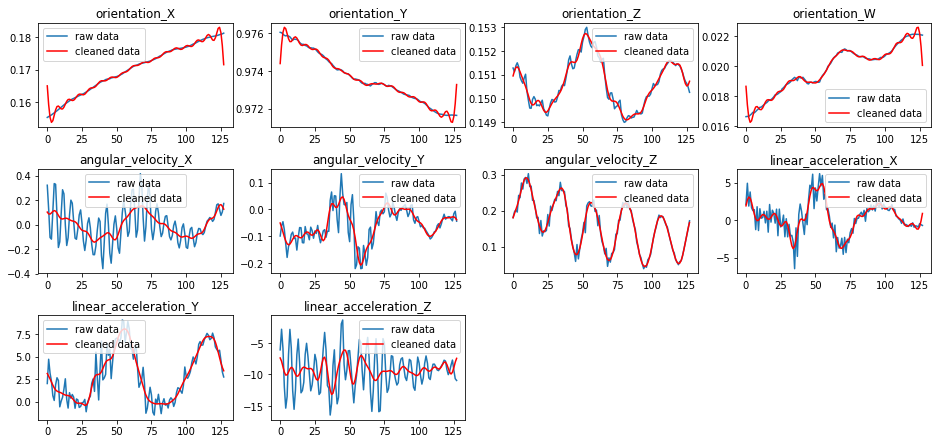

In [30]:
dato1 = X_train.iloc[128*39:128*39+128]
dato2 = cleaned.iloc[128*39:128*39+128]
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.4)
t = np.arange(0, 128, 1)
for i, col in enumerate(dato1.columns[3:]):
    plt.subplot(4, 4, i+1)
    plt.plot(t, dato1[col], label='raw data')
    plt.plot(t, dato2[col], label='cleaned data', c='r')
    plt.legend()
    plt.title(col)

## We choose a frequency threshold equal to 800 Hz which seems to fit our needs. This process is useful because our models (e.g. Random Forest) could generate patterns affected by noise which make our model useless and with poor generalization capabilities. In other words, the model will mistakenly simulate noise instead of real data.

In [31]:
cl_concrete = cleaned.iloc[128*1:128*1+128]
cl_f_concrete = cleaned.iloc[128*0:128*0+128]
cl_s_tile = cleaned.iloc[128*4:128*4+128]
cl_tiled = cleaned.iloc[128*5:128*5+128]
cl_s_pvc = cleaned.iloc[128*6:128*6+128]
cl_hard_tile_large = cleaned.iloc[128*8:128*8+128]
cl_carpet = cleaned.iloc[128*12:128*12+128]
cl_hard_tile = cleaned.iloc[128*27:128*27+128]
cl_wood = cleaned.iloc[128*39:128*39+128]

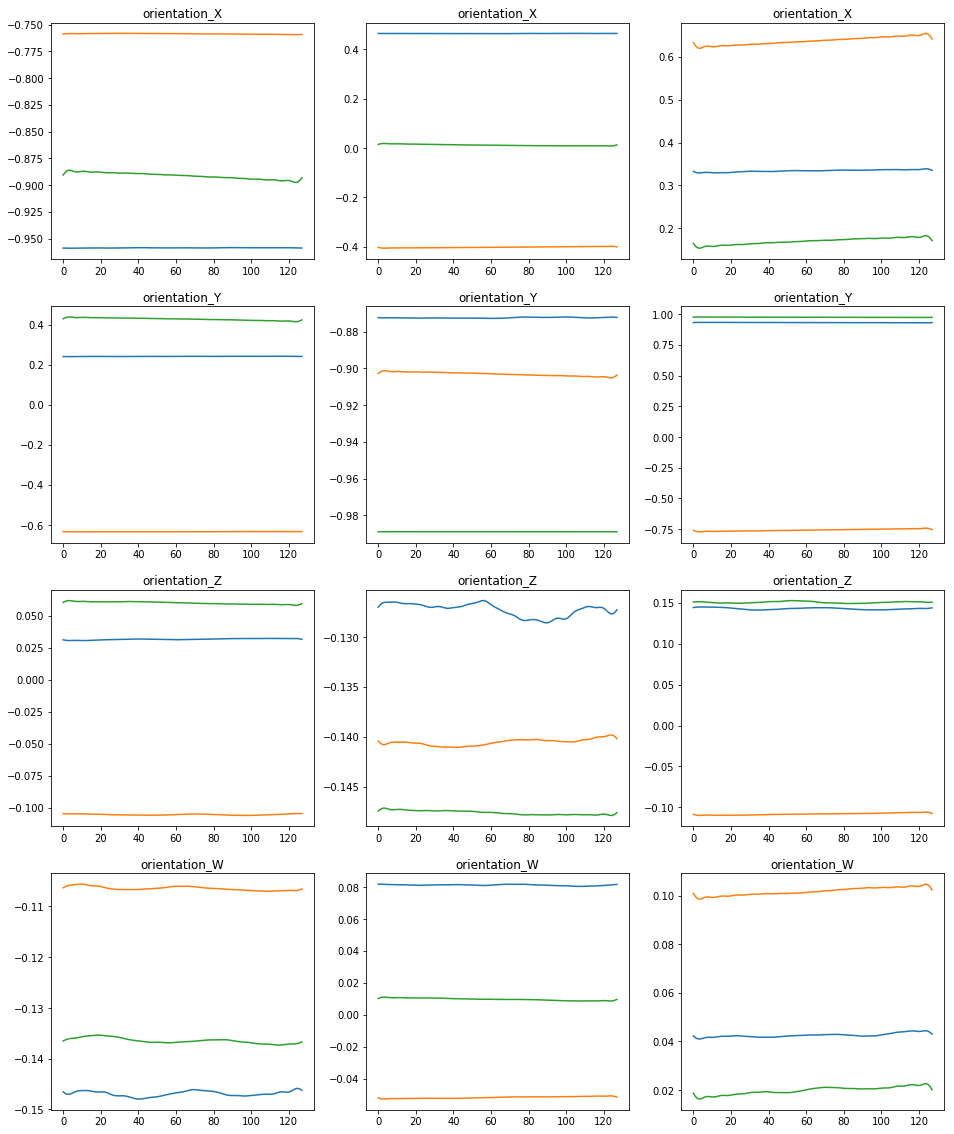

In [32]:
fig = plt.figure(figsize=(16,20))
t = np.arange(0, 128, 1)
for i, col in enumerate(X_train.columns[3:7]):
    plt.subplot(4, 3, (i*3)+1)
    plt.plot(t, cl_concrete[col])
    plt.plot(t, cl_f_concrete[col])
    plt.plot(t, cl_s_tile[col])
    plt.title(col)
    plt.subplot(4, 3, (i*3)+2)
    plt.plot(t, cl_tiled[col])
    plt.plot(t, cl_s_pvc[col])
    plt.plot(t, cl_hard_tile_large[col])
    plt.title(col)
    plt.subplot(4, 3, (i*3)+3)
    plt.plot(t, cl_carpet[col])
    plt.plot(t, cl_hard_tile[col])
    plt.plot(t, cl_wood[col])
    plt.title(col)

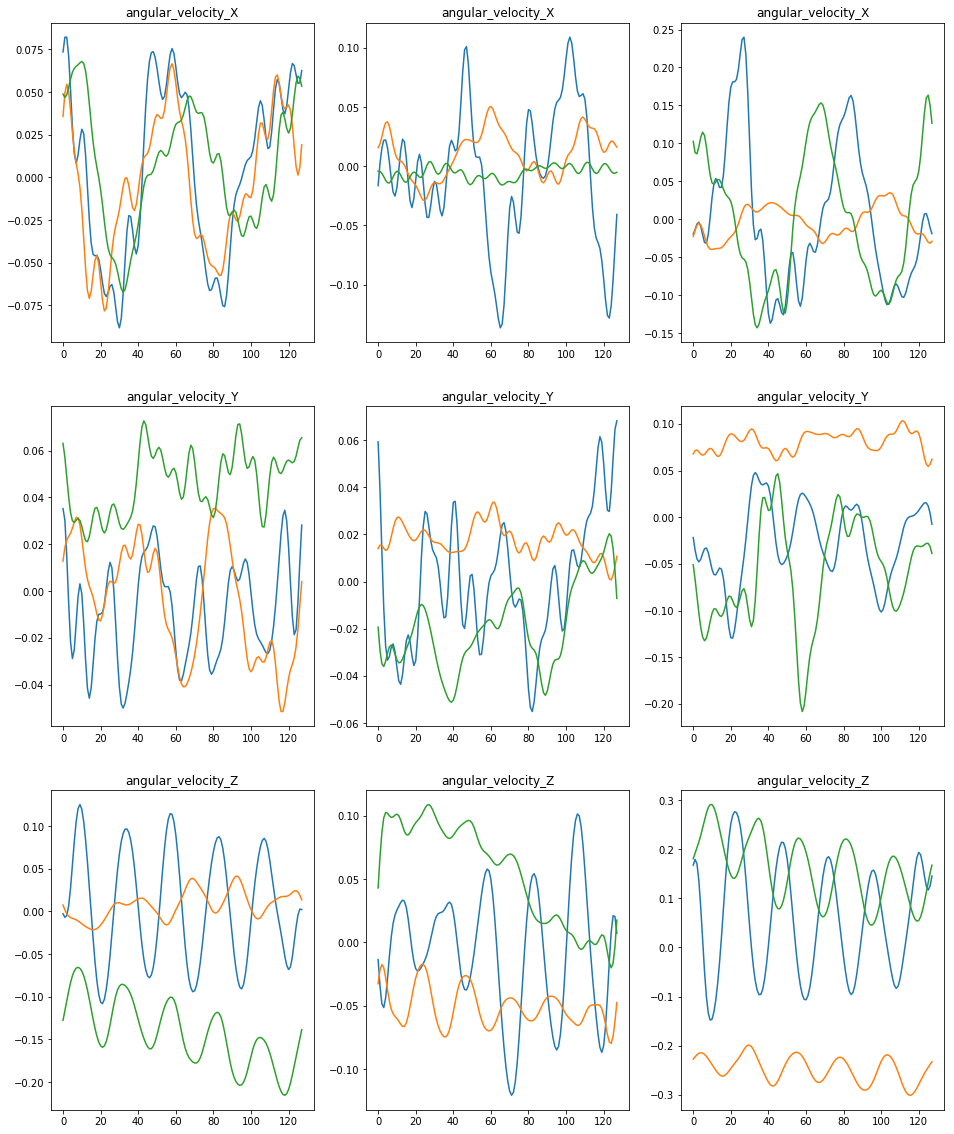

In [33]:
fig = plt.figure(figsize=(16,20))
t = np.arange(0, 128, 1)
for i, col in enumerate(X_train.columns[7:10]):
    plt.subplot(3, 3, (i*3)+1)
    plt.plot(t, cl_concrete[col])
    plt.plot(t, cl_f_concrete[col])
    plt.plot(t, cl_s_tile[col])
    plt.title(col)
    plt.subplot(3, 3, (i*3)+2)
    plt.plot(t, cl_tiled[col])
    plt.plot(t, cl_s_pvc[col])
    plt.plot(t, cl_hard_tile_large[col])
    plt.title(col)
    plt.subplot(3, 3, (i*3)+3)
    plt.plot(t, cl_carpet[col])
    plt.plot(t, cl_hard_tile[col])
    plt.plot(t, cl_wood[col])
    plt.title(col)

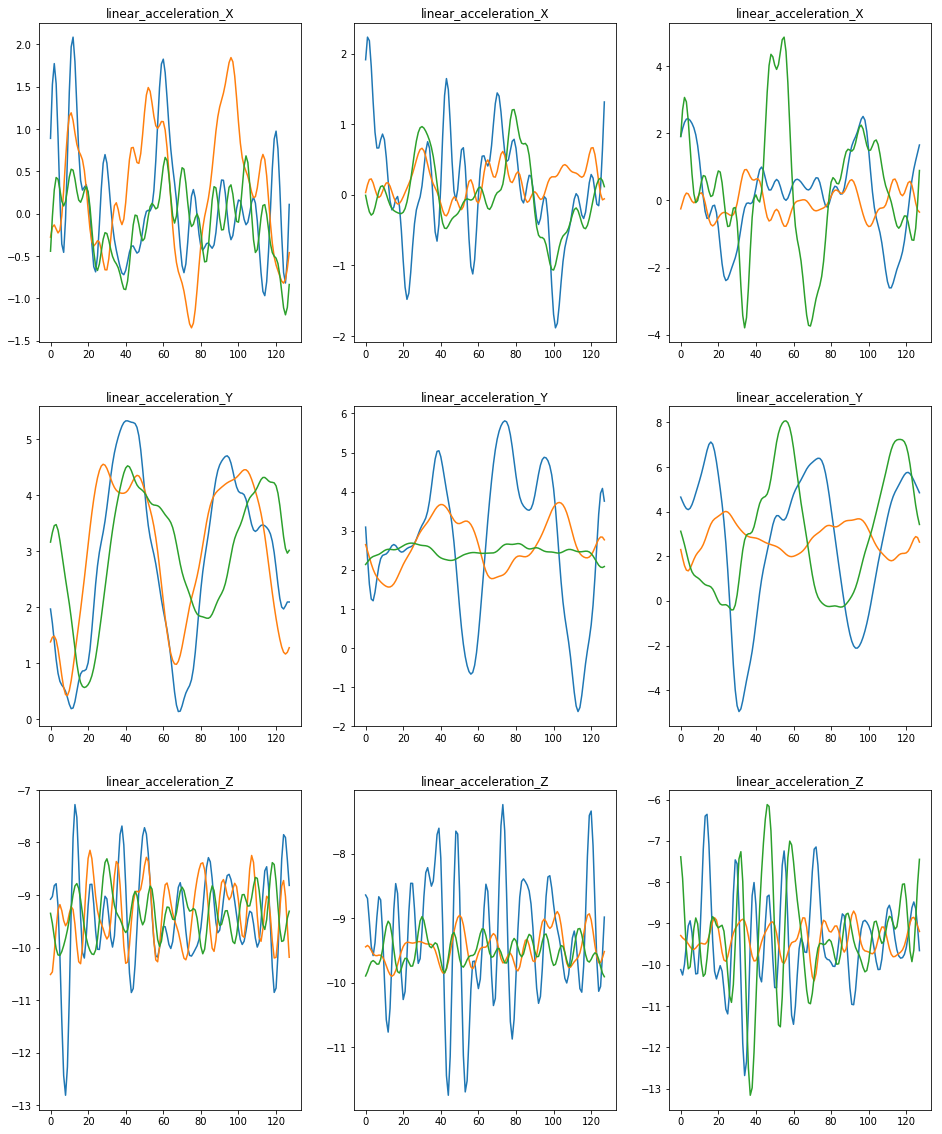

In [34]:
fig = plt.figure(figsize=(16,20))
t = np.arange(0, 128, 1)
for i, col in enumerate(X_train.columns[10:13]):
    plt.subplot(3, 3, (i*3)+1)
    plt.plot(t, cl_concrete[col])
    plt.plot(t, cl_f_concrete[col])
    plt.plot(t, cl_s_tile[col])
    plt.title(col)
    plt.subplot(3, 3, (i*3)+2)
    plt.plot(t, cl_tiled[col])
    plt.plot(t, cl_s_pvc[col])
    plt.plot(t, cl_hard_tile_large[col])
    plt.title(col)
    plt.subplot(3, 3, (i*3)+3)
    plt.plot(t, cl_carpet[col])
    plt.plot(t, cl_hard_tile[col])
    plt.plot(t, cl_wood[col])
    plt.title(col)

## An important aspect in this process is the frequency threshold choice which we investigated and set to 800 Hz.

In [35]:
fft_train = pd.read_csv('./fft_X_train.csv', engine='python')
fft_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,97.109220,81.152980,13.500690,13.628110,0.317528,0.423172,0.964051,33.717542,381.976947,1193.010000
1,0_1,0,1,0.028488,0.036071,0.015427,0.015055,0.328588,0.732443,0.734286,8.285771,24.642634,6.061498
2,0_2,0,2,0.009718,0.015306,0.033385,0.026543,3.138429,1.085432,0.140137,26.659820,110.056172,13.727553
3,0_3,0,3,0.006856,0.008771,0.011016,0.013478,0.333400,1.484564,0.665162,56.954484,0.918799,5.571661
4,0_4,0,4,0.002557,0.004402,0.002246,0.005796,0.624900,0.460014,0.581658,10.210584,23.550688,9.235857


In [36]:
cl_concrete = fft_train.iloc[128*1:128*1+128]
cl_f_concrete = fft_train.iloc[128*0:128*0+128]
cl_s_tile = fft_train.iloc[128*4:128*4+128]
cl_tiled = fft_train.iloc[128*5:128*5+128]
cl_s_pvc = fft_train.iloc[128*6:128*6+128]
cl_hard_tile_large = fft_train.iloc[128*8:128*8+128]
cl_carpet = fft_train.iloc[128*12:128*12+128]
cl_hard_tile = fft_train.iloc[128*27:128*27+128]
cl_wood = fft_train.iloc[128*39:128*39+128]

# ***************HERE WE GO AGAIN*****************

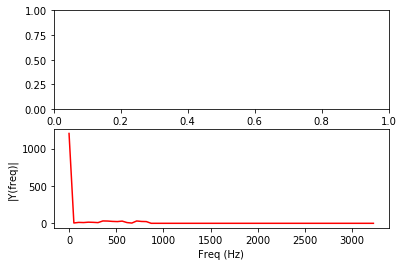

In [37]:
s_len = 128
Fs = 50
#print(fftfreq(s_len, d=20e-3/s_len))
k = np.arange(s_len)

T = 25e-1/s_len#s_len/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(s_len/2))] # one side frequency range

Y = cl_concrete.linear_acceleration_Z

fig, ax = plt.subplots(2, 1)
ax[1].plot(frq,abs(Y[:64]),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
plt.show()

# Feature Engineering
## Riportiamo il dataset con le time series in una forma svincolata dall'evoluzione temporale e semplifichiamo le feature 'orientation', 'angular velocity' e 'linear acceleration' ricavandone il modulo partendo dalle componenti fisiche. Per le feature orientation consideriamo solo le dimensioni X, Y, Z. Questo ci consente di adattare meglio i dati ai metodi di machine learning che saranno scelti. 
## Inoltre proveremo a trasformare le feature nel dominio delle frequenze per estrarre ulteriori informazioni utili alla predizione.

In [38]:
data = X_train.copy()
fe = pd.DataFrame()
data['orientation_module'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
data['angular_velocity_module'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
data['linear_acceleration_module'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5

for col in data.columns[3:16]:
    fe[col + '_mean'] = data.groupby(['series_id'])[col].mean()
    fe[col + '_max'] = data.groupby(['series_id'])[col].max()
    fe[col + '_min'] = data.groupby(['series_id'])[col].min()
    fe[col + '_absmax'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
    fe[col + '_absmin'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
    fe[col + '_range'] = fe[col + '_max'] - fe[col + '_min']
    fe[col + '_maxmin_ratio'] = fe[col + '_max'] / fe[col + '_min']
    fe[col + '_median'] = data.groupby(['series_id'])[col].median()
    fe[col + '_devstd'] = data.groupby(['series_id'])[col].std()
    fe[col + '_absavg'] = (fe[col + '_absmin'] + fe[col + '_absmax'])/2

In [39]:
fe.head()

,orientation_X_mean,orientation_X_max,orientation_X_min,orientation_X_absmax,orientation_X_absmin,orientation_X_range,orientation_X_maxmin_ratio,orientation_X_median,orientation_X_devstd,orientation_X_absavg,...,linear_acceleration_module_mean,linear_acceleration_module_max,linear_acceleration_module_min,linear_acceleration_module_absmax,linear_acceleration_module_absmin,linear_acceleration_module_range,linear_acceleration_module_maxmin_ratio,linear_acceleration_module_median,linear_acceleration_module_devstd,linear_acceleration_module_absavg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75822,-0.75953,0.75953,0.75822,0.00131,0.998275,-0.758530,0.000363,0.758875,...,9.939676,12.575577,7.117152,12.575577,7.117152,5.458424,1.766939,10.077860,0.989642,9.846364
1,-0.958606,-0.95837,-0.95896,0.95896,0.95837,0.00059,0.999385,-0.958595,0.000151,0.958665,...,10.082444,16.986332,5.867993,16.986332,5.867993,11.118339,2.894743,10.069950,1.826016,11.427163
2,-0.512057,-0.50944,-0.51434,0.51434,0.50944,0.00490,0.990473,-0.512035,0.001377,0.511890,...,10.035741,12.725500,6.794325,12.725500,6.794325,5.931175,1.872960,10.082289,0.944637,9.759913
3,-0.939169,-0.93884,-0.93968,0.93968,0.93884,0.00084,0.999106,-0.939170,0.000227,0.939260,...,10.888094,20.833299,2.064233,20.833299,2.064233,18.769065,10.092512,10.925683,3.102236,11.448766
4,-0.891301,-0.88673,-0.89689,0.89689,0.88673,0.01016,0.988672,-0.890940,0.002955,0.891810,...,9.892815,11.485482,8.071708,11.485482,8.071708,3.413774,1.422931,10.005620,0.765162,9.778595


In [40]:
for col in fft_train.columns[3:13]:
    fe['fft_' + col + '_mean'] = fft_train.groupby(['series_id'])[col].mean()
    fe['fft_' + col + '_max'] = fft_train.groupby(['series_id'])[col].max()
    fe['fft_' + col + '_min'] = fft_train.groupby(['series_id'])[col].min()
    fe['fft_' + col + '_range'] = fe['fft_' + col + '_max'] - fe['fft_' + col + '_min']
    fe['fft_' + col + '_absmax'] = fft_train.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
    fe['fft_' + col + '_absmin'] = fft_train.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
    fe['fft_' + col + '_absavg'] = (fe['fft_' + col + '_absmin'] + fe['fft_' + col + '_absmax'])/2

In [41]:
fe.head()

,orientation_X_mean,orientation_X_max,orientation_X_min,orientation_X_absmax,orientation_X_absmin,orientation_X_range,orientation_X_maxmin_ratio,orientation_X_median,orientation_X_devstd,orientation_X_absavg,...,fft_linear_acceleration_Y_absmax,fft_linear_acceleration_Y_absmin,fft_linear_acceleration_Y_absavg,fft_linear_acceleration_Z_mean,fft_linear_acceleration_Z_max,fft_linear_acceleration_Z_min,fft_linear_acceleration_Z_range,fft_linear_acceleration_Z_absmax,fft_linear_acceleration_Z_absmin,fft_linear_acceleration_Z_absavg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75822,-0.75953,0.75953,0.75822,0.00131,0.998275,-0.758530,0.000363,0.758875,...,381.976947,0.0,190.988473,14.913671,1193.0100,0.0,1193.0100,1193.0100,0.0,596.50500
1,-0.958606,-0.95837,-0.95896,0.95896,0.95837,0.00059,0.999385,-0.958595,0.000151,0.958665,...,354.328697,0.0,177.164348,19.645015,1201.7791,0.0,1201.7791,1201.7791,0.0,600.88955
2,-0.512057,-0.50944,-0.51434,0.51434,0.50944,0.00490,0.990473,-0.512035,0.001377,0.511890,...,369.503305,0.0,184.751653,15.594239,1202.6602,0.0,1202.6602,1202.6602,0.0,601.33010
3,-0.939169,-0.93884,-0.93968,0.93968,0.93884,0.00084,0.999106,-0.939170,0.000227,0.939260,...,340.214058,0.0,170.107029,24.773660,1209.7490,0.0,1209.7490,1209.7490,0.0,604.87450
4,-0.891301,-0.88673,-0.89689,0.89689,0.88673,0.01016,0.988672,-0.890940,0.002955,0.891810,...,381.631730,0.0,190.815865,13.211315,1196.7985,0.0,1196.7985,1196.7985,0.0,598.39925


confusion matrix(accuratezza, precisione e recall)

random forest, adaboosting, xgboosting, abm, catboosting, naive bayes + altri, addestrati con parmatri standard e si cercano magari i primi 5 che hanno un'accuratezza migliore e gli altri si scartano. sui 5 best vai a fare ottimizzazione parametri e poi ensembling dei classificatori per migliorare le prestazioni. ALBERI VS LINEAR MODEL
per scegliere le feature nel FE, grafichiamo quello che ne risulta per capire se una feature potrebbe essere buona per gli alberi perchè magari separa i grafici. una votla addestrato random forest è possibile vedere feature improtance per capire se alcune feature non servono.
K-FOLD STRATIFIED, 